Found 100 parquet files
Starting to load files...


Loading Files: 100%|██████████| 100/100 [00:00<00:00, 564.97it/s]


Loaded 20 files so far, latest: ABOS
Loaded 40 files so far, latest: ACM
Loaded 60 files so far, latest: ADI
Loaded 80 files so far, latest: AEHR
Loaded 100 files so far, latest: AFRM
Successfully loaded data for 100 stocks


Analyzing Predictions: 100%|██████████| 100/100 [00:00<00:00, 113.24it/s]


Combined dataset has 25100 rows and covers 100 stocks


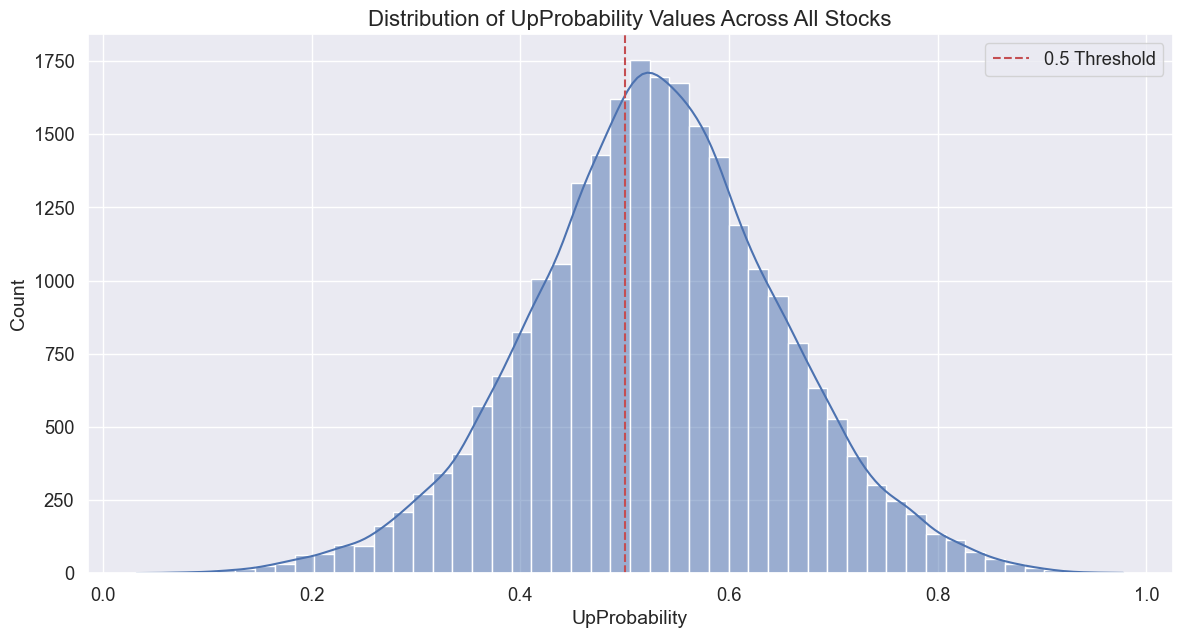

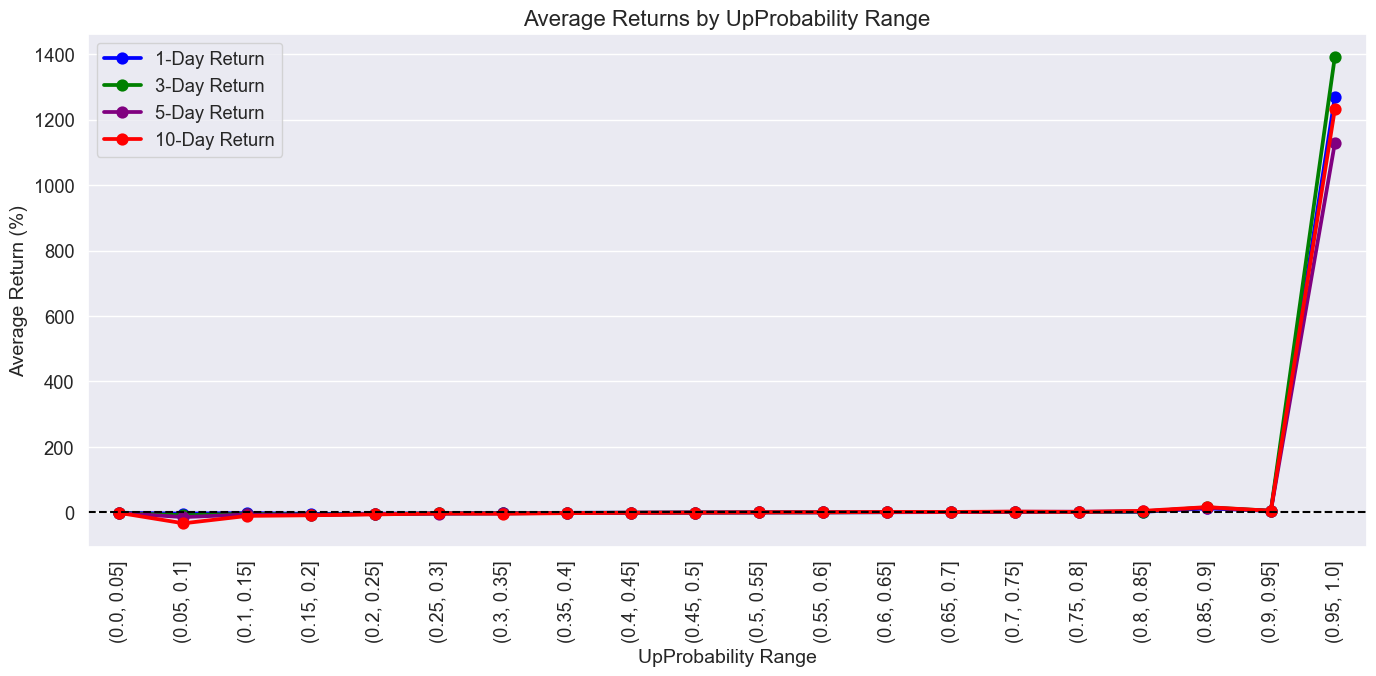

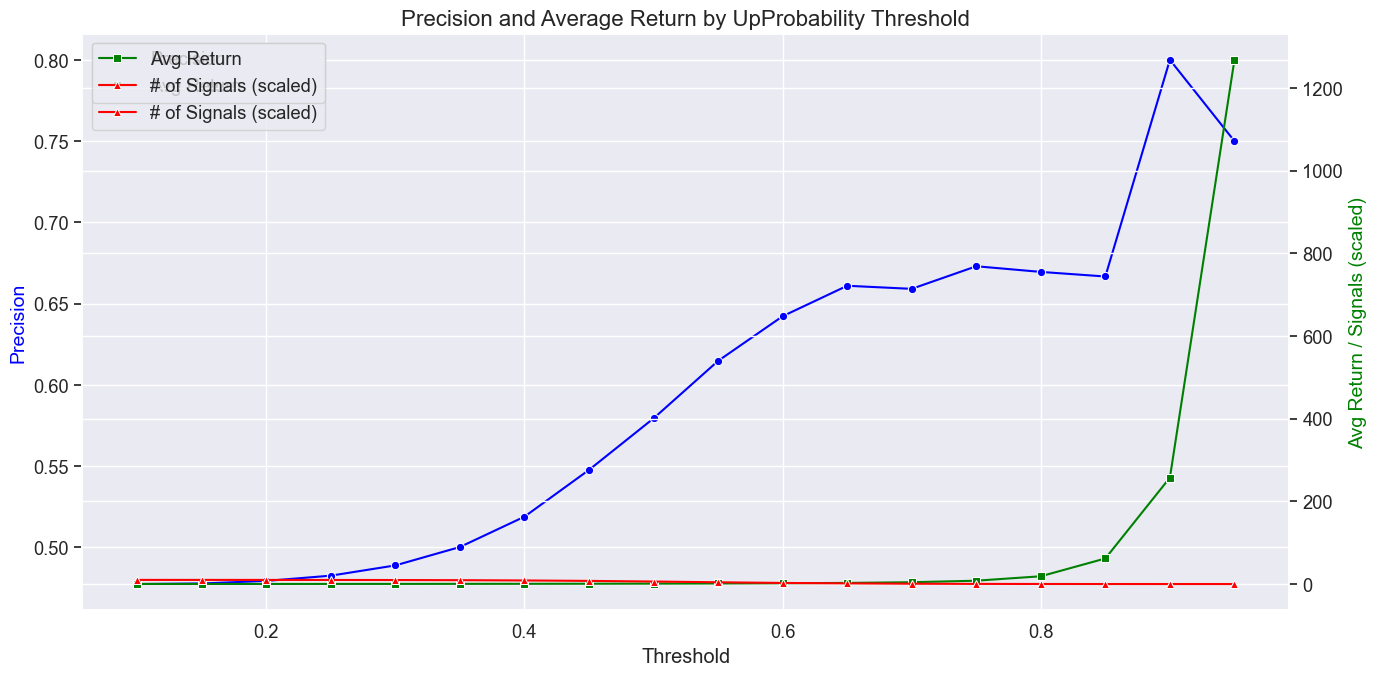

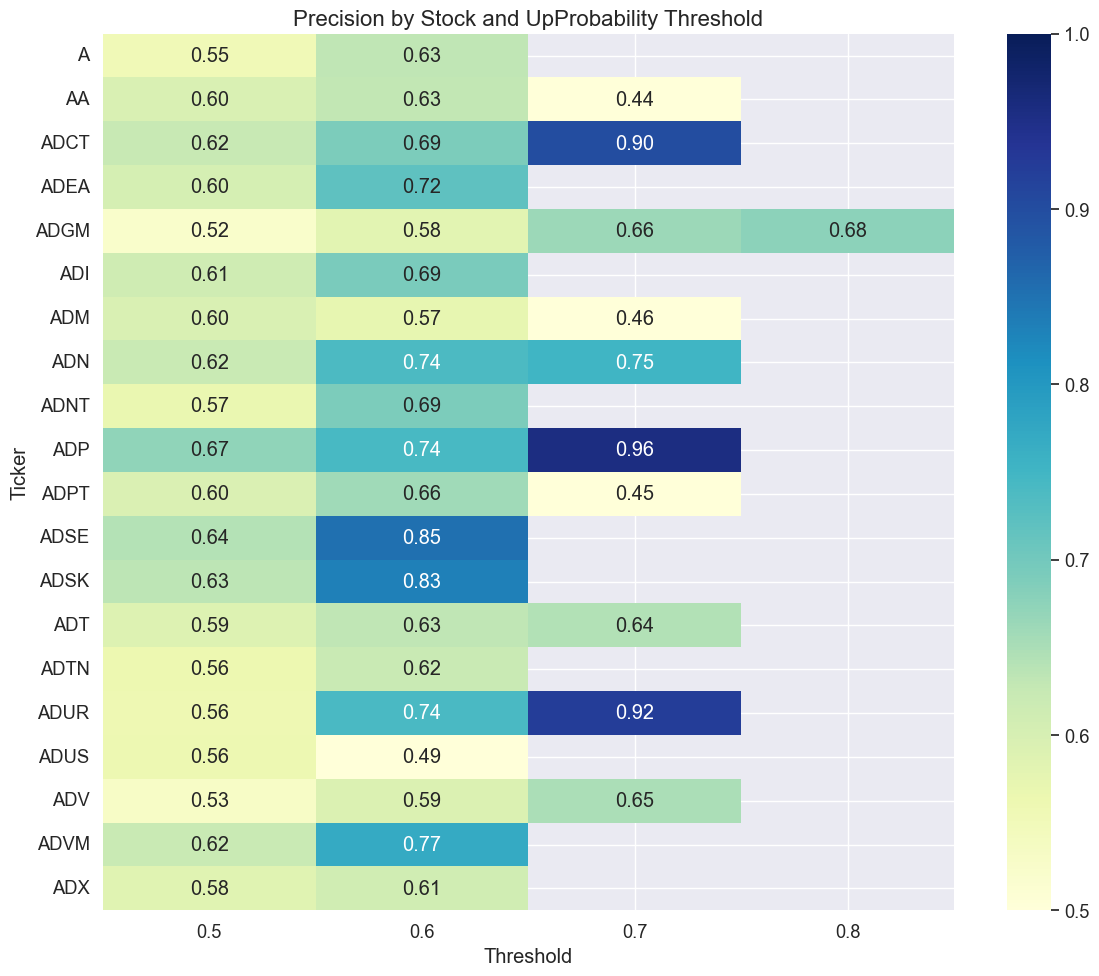

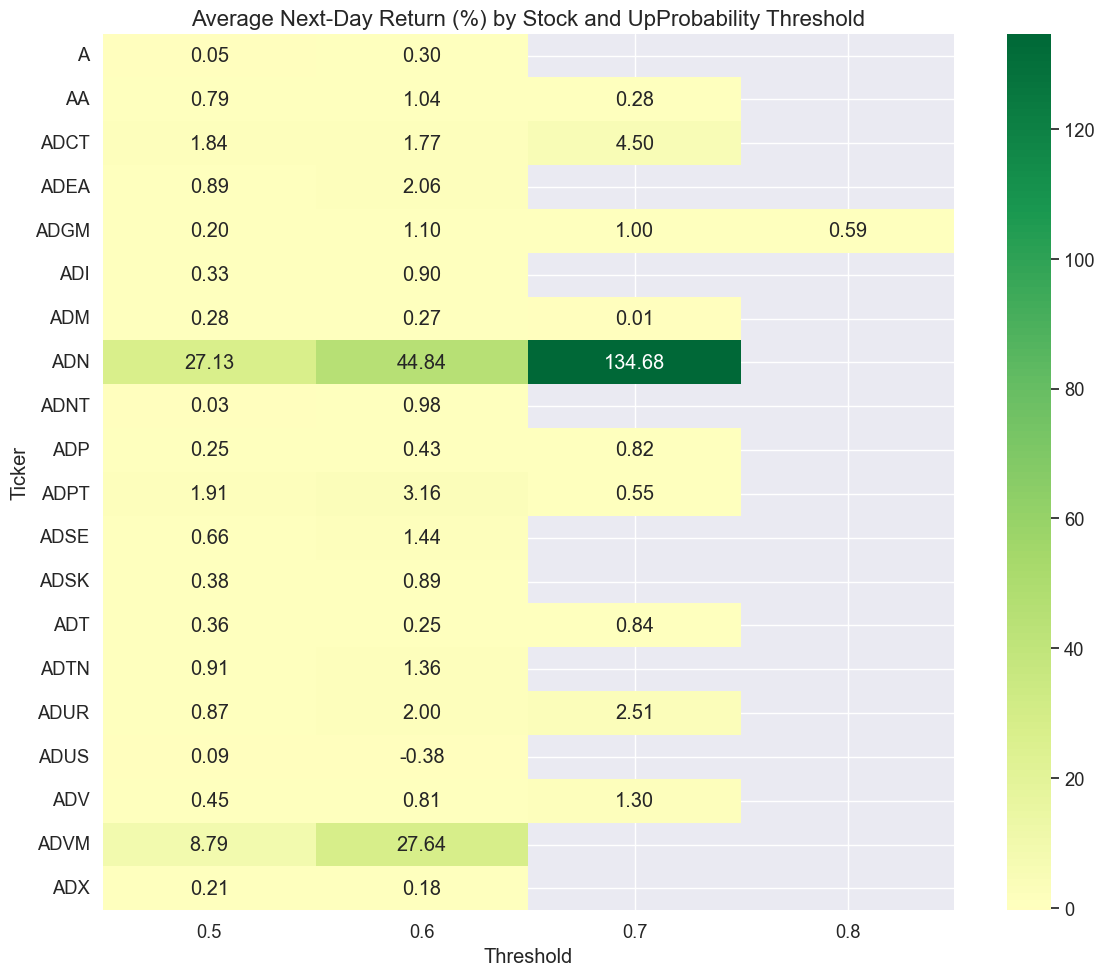

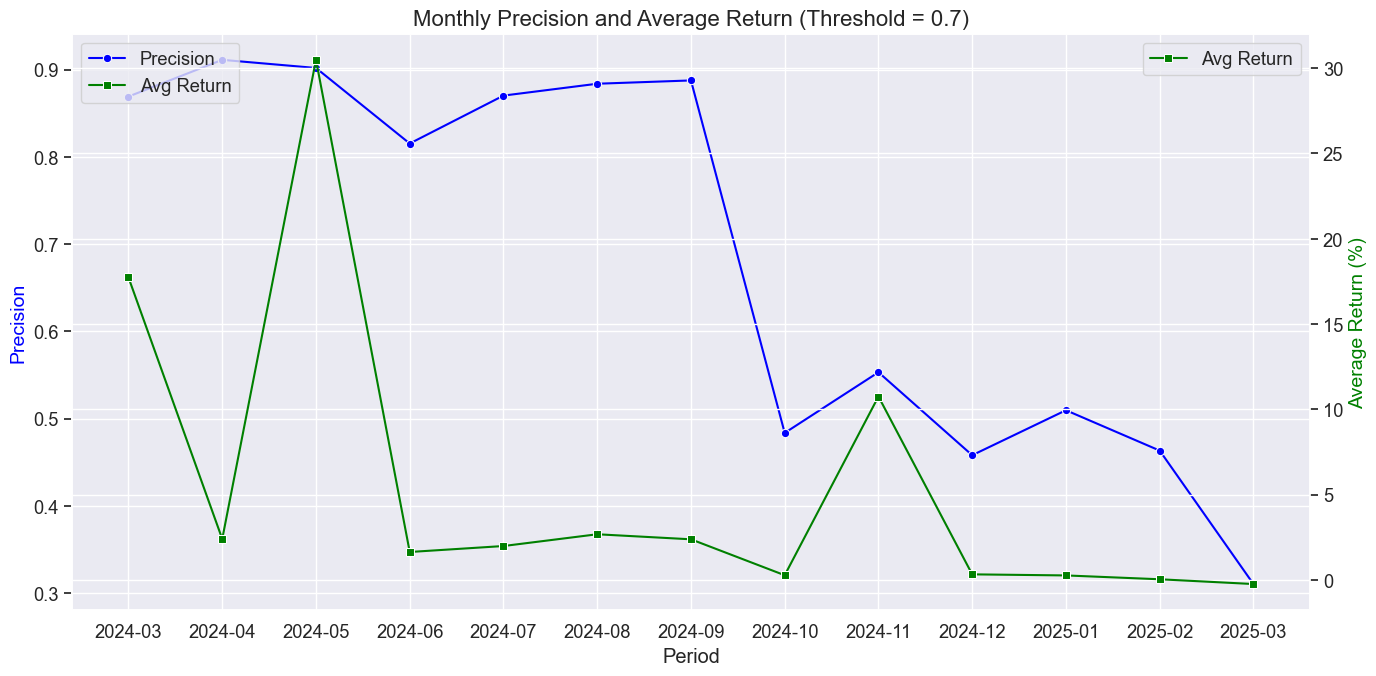

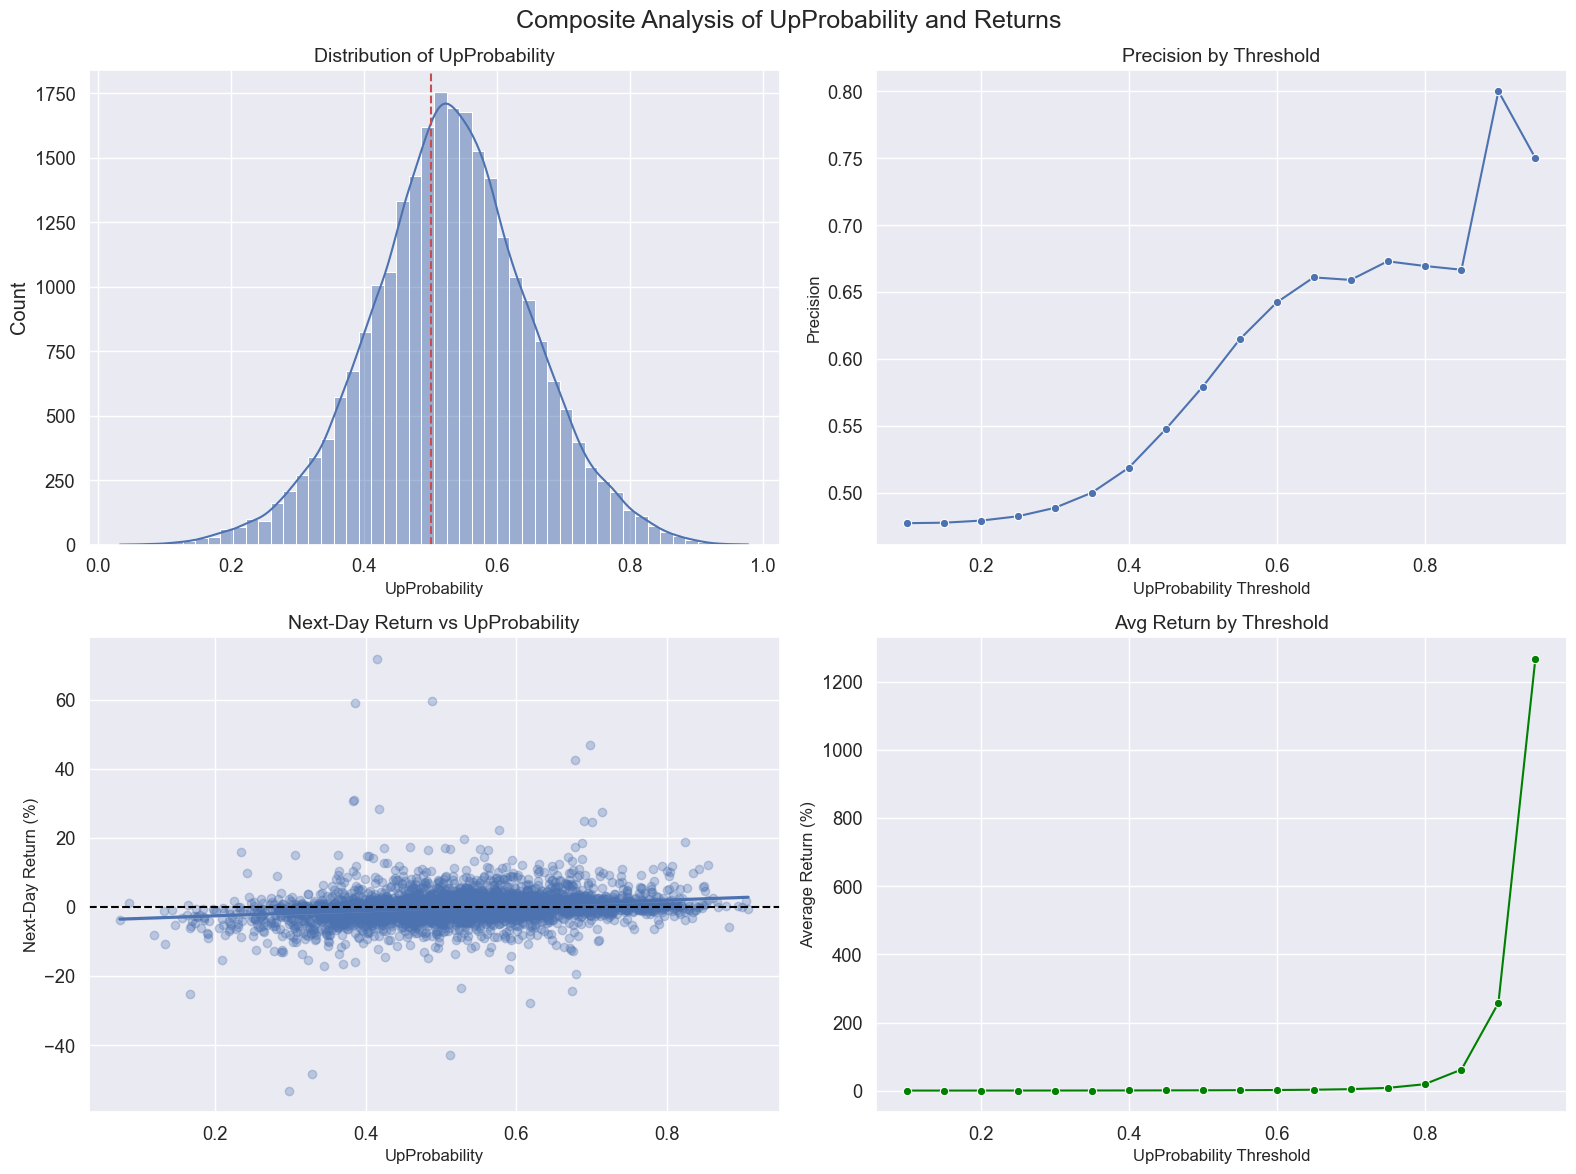


Precision Summary by Threshold:
    Threshold  Precision  Total_Predictions  Avg_Return_When_Predicted_Up
0        0.10   0.477403              25092                      0.235041
1        0.15   0.477760              25067                      0.236945
2        0.20   0.479325              24958                      0.256673
3        0.25   0.482562              24745                      0.290490
4        0.30   0.488880              24280                      0.349080
5        0.35   0.500192              23415                      0.443298
6        0.40   0.518861              21711                      0.565845
7        0.45   0.547658              19063                      0.754129
8        0.50   0.579358              15241                      0.992893
9        0.55   0.614717              10722                      1.339420
10       0.60   0.642217               6694                      1.862098
11       0.65   0.660960               3855                      2.739606
12   

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import multiprocessing
import traceback
from datetime import datetime, timedelta
from sklearn.metrics import precision_score, confusion_matrix, precision_recall_curve
import logging
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

# Function to load data from a single file (provided by user)
def load_data(file_path, last_trading_date):
    try:
        table = pq.read_table(file_path)
        df = table.to_pandas()
        
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
        
        # Use the last trading date
        yesterday = last_trading_date
        start_date = yesterday - timedelta(days=400)
        
        df = df[(df['Date'].dt.date >= start_date) & (df['Date'].dt.date <= yesterday)]
        
        if len(df) < 252:
            logging.info(f"Skipping {file_path} due to insufficient data: {len(df)} days")
            return None
        
        df = df.iloc[-252:]  # Keep up to 252 trading days (approx 1 year)
        
        required_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
                            'Distance to Support (%)', 'Distance to Resistance (%)', 
                            'UpProbability', 'UpPrediction']
        
        if all(col in df.columns for col in required_columns):
            for col in df.select_dtypes(include=['float64']).columns:
                df[col] = df[col].round(4).astype(np.float32)
            
            return (os.path.basename(file_path).replace('.parquet', ''), df)
        else:
            missing_columns = [col for col in required_columns if col not in df.columns]
            print(f"Skipping {file_path} due to missing columns: {missing_columns}")

    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        traceback.print_exc()

    return None

# Function to load data in parallel (provided by user)
def parallel_load_data(file_paths, last_trading_date):
    with multiprocessing.Pool() as pool:
        results = list(tqdm(pool.starmap(load_data, [(fp, last_trading_date) for fp in file_paths]), 
                            total=len(file_paths), desc="Loading Files"))
    return [result for result in results if result is not None]

def analyze_rf_predictions(max_files=None):
    # 1. Load all the data files
    data_folder = "Data/RFpredictions"
    file_paths = glob.glob(os.path.join(data_folder, "*.parquet"))
    
    if max_files:
        file_paths = file_paths[:max_files]
    else:
        # Limit to 1000 files if None specified to avoid memory issues
        file_paths = file_paths[:1000]
        
    print(f"Found {len(file_paths)} parquet files")
    
    # Simplified direct loading instead of using parallel processing
    stock_data = []
    
    print("Starting to load files...")
    for i, file_path in enumerate(tqdm(file_paths[:100], desc="Loading Files")):  # Start with just 100 files
        try:
            # Simple direct loading
            table = pq.read_table(file_path)
            df = table.to_pandas()
            
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date')
            
            # Get the ticker name from the filename
            ticker = os.path.basename(file_path).replace('.parquet', '')
            
            # Just take the last year of data
            if len(df) > 252:
                df = df.iloc[-252:]
                
            # Check if dataframe has required columns
            required_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'UpProbability']
            if all(col in df.columns for col in required_columns):
                stock_data.append((ticker, df))
                
                # Print a status update every 20 files
                if (i+1) % 20 == 0:
                    print(f"Loaded {i+1} files so far, latest: {ticker}")
            
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            
    print(f"Successfully loaded data for {len(stock_data)} stocks")
    
    # 2. Calculate future returns and analyze prediction accuracy
    all_results = []
    prediction_outcomes = []
    
    for ticker, df in tqdm(stock_data, desc="Analyzing Predictions"):
        # Calculate the next day's return
        df['Next_Day_Return'] = df['Close'].pct_change(1).shift(-1) * 100
        
        # Calculate forward returns for different horizons
        df['Return_1d'] = df['Close'].pct_change(1).shift(-1) * 100
        df['Return_3d'] = df['Close'].pct_change(3).shift(-3) * 100
        df['Return_5d'] = df['Close'].pct_change(5).shift(-5) * 100
        df['Return_10d'] = df['Close'].pct_change(10).shift(-10) * 100
        
        # Create an actual positive class label (if next day return > 0)
        df['Actual_Up'] = (df['Next_Day_Return'] > 0).astype(int)
        
        # Drop rows with NaN in critical columns
        df = df.dropna(subset=['UpProbability', 'Next_Day_Return', 'Actual_Up'])
        
        # Add ticker info
        df['Ticker'] = ticker
        
        # Keeping only the results with good amount of data
        if len(df) > 100:
            all_results.append(df)
            
            # Create pairs of UpProbability and actual outcome for each day
            for idx, row in df.iterrows():
                prediction_outcomes.append({
                    'Ticker': ticker,
                    'Date': row['Date'],
                    'UpProbability': row['UpProbability'],
                    'UpPrediction': row['UpPrediction'],
                    'Actual_Up': row['Actual_Up'],
                    'Next_Day_Return': row['Next_Day_Return'],
                    'Return_3d': row['Return_3d'],
                    'Return_5d': row['Return_5d'],
                    'Return_10d': row['Return_10d']
                })
    
    # Combine all results into a single dataframe
    if not all_results:
        print("No valid results found.")
        return
        
    combined_df = pd.concat(all_results, ignore_index=True)
    pred_outcomes_df = pd.DataFrame(prediction_outcomes)
    
    print(f"Combined dataset has {len(combined_df)} rows and covers {combined_df['Ticker'].nunique()} stocks")
    
    # 3. EDA and Visualization
    
    # Figure 1: Distribution of Up Probabilities
    plt.figure(figsize=(14, 7))
    sns.histplot(pred_outcomes_df['UpProbability'], bins=50, kde=True)
    plt.title('Distribution of UpProbability Values Across All Stocks', fontsize=16)
    plt.xlabel('UpProbability', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.axvline(0.5, color='r', linestyle='--', label='0.5 Threshold')
    plt.legend()
    plt.show()
    
    # Figure 2: Analyze how upProbability relates to actual returns for different time horizons
    
    # Group by probability ranges and calculate average returns
    prob_bins = np.arange(0, 1.05, 0.05)
    pred_outcomes_df['ProbabilityBin'] = pd.cut(pred_outcomes_df['UpProbability'], bins=prob_bins)
    
    returns_by_prob = pred_outcomes_df.groupby('ProbabilityBin')[
        ['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d']
    ].mean().reset_index()
    
    # Plot average returns by probability bin
    plt.figure(figsize=(14, 7))
    sns.pointplot(x='ProbabilityBin', y='Next_Day_Return', data=returns_by_prob, color='blue', label='1-Day Return')
    sns.pointplot(x='ProbabilityBin', y='Return_3d', data=returns_by_prob, color='green', label='3-Day Return')
    sns.pointplot(x='ProbabilityBin', y='Return_5d', data=returns_by_prob, color='purple', label='5-Day Return')
    sns.pointplot(x='ProbabilityBin', y='Return_10d', data=returns_by_prob, color='red', label='10-Day Return')
    
    plt.title('Average Returns by UpProbability Range', fontsize=16)
    plt.xlabel('UpProbability Range', fontsize=14)
    plt.ylabel('Average Return (%)', fontsize=14)
    plt.xticks(rotation=90)
    plt.axhline(0, color='black', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Figure 3: Calculate precision at different probability thresholds
    thresholds = np.arange(0.1, 1.0, 0.05)
    precision_results = []
    
    for threshold in thresholds:
        # Convert probability to predictions based on threshold
        predictions = (pred_outcomes_df['UpProbability'] > threshold).astype(int)
        actuals = pred_outcomes_df['Actual_Up']
        
        # Calculate metrics
        tp = ((predictions == 1) & (actuals == 1)).sum()
        fp = ((predictions == 1) & (actuals == 0)).sum()
        
        # Calculate precision (avoid division by zero)
        if tp + fp > 0:
            precision = tp / (tp + fp)
        else:
            precision = 0
            
        # Calculate average return when model predicts "up"
        avg_return_when_predicted_up = pred_outcomes_df.loc[predictions == 1, 'Next_Day_Return'].mean()
        
        precision_results.append({
            'Threshold': threshold,
            'Precision': precision,
            'TP': tp,
            'FP': fp,
            'Total_Predictions': (predictions == 1).sum(),
            'Avg_Return_When_Predicted_Up': avg_return_when_predicted_up
        })
    
    precision_df = pd.DataFrame(precision_results)
    
    # Plot precision vs threshold
    plt.figure(figsize=(14, 7))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot precision
    sns.lineplot(x='Threshold', y='Precision', data=precision_df, ax=ax1, color='blue', marker='o', label='Precision')
    
    # Plot average return
    sns.lineplot(x='Threshold', y='Avg_Return_When_Predicted_Up', data=precision_df, ax=ax2, color='green', marker='s', label='Avg Return')
    
    # Plot number of signals (scaled down to fit on same axis)
    signal_scale_factor = precision_df['Total_Predictions'].max() / 10
    # Create a new column for scaled signals
    precision_df['Scaled_Signals'] = precision_df['Total_Predictions'] / signal_scale_factor
    sns.lineplot(x='Threshold', y='Scaled_Signals', data=precision_df, ax=ax2, color='red', marker='^', label='# of Signals (scaled)')
    
    ax1.set_ylabel('Precision', color='blue', fontsize=14)
    ax2.set_ylabel('Avg Return / Signals (scaled)', color='green', fontsize=14)
    
    plt.title('Precision and Average Return by UpProbability Threshold', fontsize=16)
    plt.xlabel('UpProbability Threshold', fontsize=14)
    
    # Add a legend for both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Figure 4: Create a heatmap of precision by stock and probability threshold
    # Sample a subset of stocks for clarity
    top_stocks = combined_df['Ticker'].value_counts().head(20).index.tolist()
    precision_by_stock = []
    
    for ticker in top_stocks:
        ticker_data = pred_outcomes_df[pred_outcomes_df['Ticker'] == ticker]
        
        for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
            predictions = (ticker_data['UpProbability'] > threshold).astype(int)
            actuals = ticker_data['Actual_Up']
            
            if sum(predictions) > 10:  # Only include if we have enough predictions
                tp = ((predictions == 1) & (actuals == 1)).sum()
                fp = ((predictions == 1) & (actuals == 0)).sum()
                
                if tp + fp > 0:
                    precision = tp / (tp + fp)
                else:
                    precision = 0
                    
                avg_return = ticker_data.loc[predictions == 1, 'Next_Day_Return'].mean()
                
                precision_by_stock.append({
                    'Ticker': ticker,
                    'Threshold': threshold,
                    'Precision': precision,
                    'Avg_Return': avg_return,
                    'Signal_Count': sum(predictions)
                })
    
    if precision_by_stock:
        stock_precision_df = pd.DataFrame(precision_by_stock)
        
        # Create the precision heatmap by stock and threshold
        pivot_df = stock_precision_df.pivot(index='Ticker', columns='Threshold', values='Precision')
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f', vmin=0.5, vmax=1.0)
        plt.title('Precision by Stock and UpProbability Threshold', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Create the average return heatmap by stock and threshold
        pivot_return_df = stock_precision_df.pivot(index='Ticker', columns='Threshold', values='Avg_Return')
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(pivot_return_df, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
        plt.title('Average Next-Day Return (%) by Stock and UpProbability Threshold', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # Figure 5: Analyze precision over time to see if model performance is stable
    # Create monthly periods
    pred_outcomes_df['YearMonth'] = pred_outcomes_df['Date'].dt.to_period('M')
    
    # Calculate precision for each month using 0.7 threshold (or whatever threshold looks best from earlier analysis)
    monthly_precision = []
    threshold = 0.7
    
    for period in sorted(pred_outcomes_df['YearMonth'].unique()):
        period_data = pred_outcomes_df[pred_outcomes_df['YearMonth'] == period]
        predictions = (period_data['UpProbability'] > threshold).astype(int)
        actuals = period_data['Actual_Up']
        
        if sum(predictions) > 20:  # Only include months with enough predictions
            tp = ((predictions == 1) & (actuals == 1)).sum()
            fp = ((predictions == 1) & (actuals == 0)).sum()
            
            if tp + fp > 0:
                precision = tp / (tp + fp)
            else:
                precision = 0
                
            avg_return = period_data.loc[predictions == 1, 'Next_Day_Return'].mean()
            
            monthly_precision.append({
                'Period': period,
                'Precision': precision,
                'Avg_Return': avg_return,
                'Signal_Count': sum(predictions)
            })
    
    if monthly_precision:
        monthly_df = pd.DataFrame(monthly_precision)
        monthly_df['Period'] = monthly_df['Period'].astype(str)
        
        plt.figure(figsize=(14, 7))
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        
        sns.lineplot(x='Period', y='Precision', data=monthly_df, ax=ax1, color='blue', marker='o', label='Precision')
        sns.lineplot(x='Period', y='Avg_Return', data=monthly_df, ax=ax2, color='green', marker='s', label='Avg Return')
        
        ax1.set_ylabel('Precision', color='blue', fontsize=14)
        ax2.set_ylabel('Average Return (%)', color='green', fontsize=14)
        
        plt.title(f'Monthly Precision and Average Return (Threshold = {threshold})', fontsize=16)
        plt.xlabel('Month', fontsize=14)
        plt.xticks(rotation=90)
        
        # Add a legend for both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    # Figure 6: Create a composite visualization showing the relationship between UpProbability and returns
    plt.figure(figsize=(16, 12))
    
    # Create a grid of subplots
    gs = plt.GridSpec(2, 2, figure=plt.gcf())
    
    # 1. Probability Distribution
    ax1 = plt.subplot(gs[0, 0])
    sns.histplot(pred_outcomes_df['UpProbability'], bins=50, kde=True, ax=ax1)
    ax1.set_title('Distribution of UpProbability', fontsize=14)
    ax1.set_xlabel('UpProbability', fontsize=12)
    ax1.axvline(0.5, color='r', linestyle='--')
    
    # 2. Precision by Threshold
    ax2 = plt.subplot(gs[0, 1])
    sns.lineplot(x='Threshold', y='Precision', data=precision_df, ax=ax2, marker='o')
    ax2.set_title('Precision by Threshold', fontsize=14)
    ax2.set_xlabel('UpProbability Threshold', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    
    # 3. Returns by Probability
    ax3 = plt.subplot(gs[1, 0])
    # Safely sample from the dataframe
    sample_size = min(5000, len(pred_outcomes_df)) if len(pred_outcomes_df) > 0 else 0
    if sample_size > 0:
        sample_df = pred_outcomes_df.sample(sample_size)
        sns.regplot(x='UpProbability', y='Next_Day_Return', data=sample_df, 
                    scatter_kws={'alpha':0.3}, ax=ax3)
    ax3.set_title('Next-Day Return vs UpProbability', fontsize=14)
    ax3.set_xlabel('UpProbability', fontsize=12)
    ax3.set_ylabel('Next-Day Return (%)', fontsize=12)
    ax3.axhline(0, color='black', linestyle='--')
    
    # 4. Average Return by Threshold
    ax4 = plt.subplot(gs[1, 1])
    sns.lineplot(x='Threshold', y='Avg_Return_When_Predicted_Up', data=precision_df, ax=ax4, marker='o', color='green')
    ax4.set_title('Avg Return by Threshold', fontsize=14)
    ax4.set_xlabel('UpProbability Threshold', fontsize=12)
    ax4.set_ylabel('Average Return (%)', fontsize=12)
    
    plt.tight_layout()
    plt.suptitle('Composite Analysis of UpProbability and Returns', fontsize=18)
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Print summary statistics for different thresholds
    print("\nPrecision Summary by Threshold:")
    print(precision_df[['Threshold', 'Precision', 'Total_Predictions', 'Avg_Return_When_Predicted_Up']])
    
    # Calculate the best threshold based on combined score of precision and return
    precision_df['Combined_Score'] = precision_df['Precision'] * precision_df['Avg_Return_When_Predicted_Up']
    best_threshold = precision_df.loc[precision_df['Combined_Score'].idxmax(), 'Threshold']
    
    print(f"\nBest threshold based on combined precision and return: {best_threshold:.2f}")
    best_row = precision_df[precision_df['Threshold'] == best_threshold].iloc[0]
    print(f"At this threshold - Precision: {best_row['Precision']:.4f}, Avg Return: {best_row['Avg_Return_When_Predicted_Up']:.4f}%, Signals: {best_row['Total_Predictions']}")
    
    # Calculate what would happen if we just predicted "UP" every day (benchmark)
    always_up_precision = pred_outcomes_df['Actual_Up'].mean()
    print(f"Benchmark precision (always predicting UP): {always_up_precision:.4f}")
    
    # Return the dataframes for potential further analysis
    return combined_df, pred_outcomes_df, precision_df

# Execute the analysis function with a smaller sample for testing
# Start with just 100 files to make sure everything works
combined_df, pred_outcomes_df, precision_df = analyze_rf_predictions(max_files=100)

Found 100 parquet files
Starting to load files...


Loading Files: 100%|██████████| 100/100 [00:00<00:00, 578.03it/s]

Loaded 20 files so far, latest: ABOS
Loaded 40 files so far, latest: ACM
Loaded 60 files so far, latest: ADI
Loaded 80 files so far, latest: AEHR
Loaded 100 files so far, latest: AFRM
Successfully loaded data for 100 stocks


Combined dataset has 54428 rows and covers 100 stocks


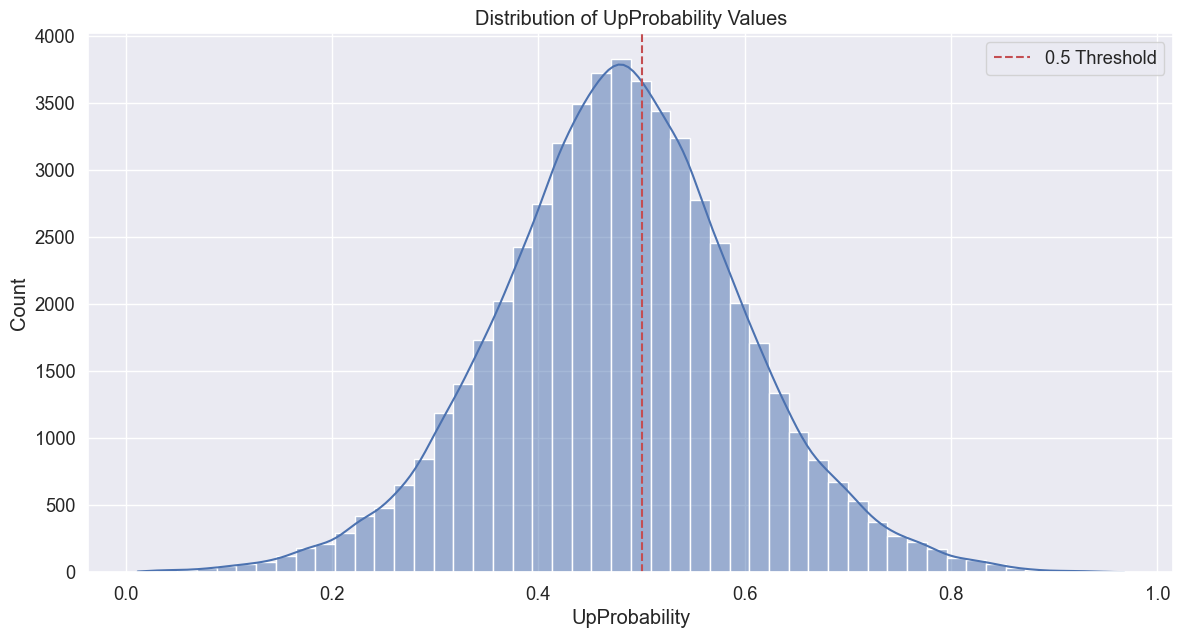

Basic statistics of UpProbability:
count    54328.000000
mean         0.478992
std          0.119570
min          0.011562
25%          0.403715
50%          0.479382
75%          0.554325
max          0.967615
Name: UpProbability, dtype: float64


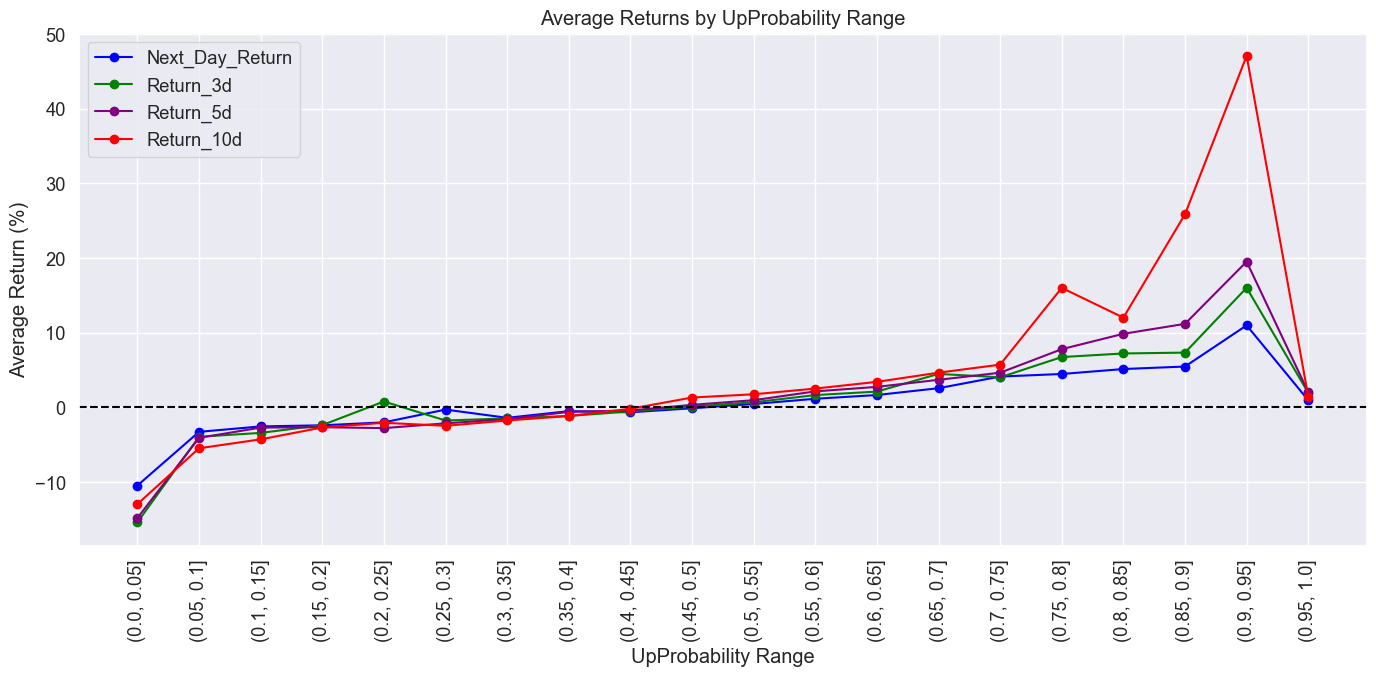

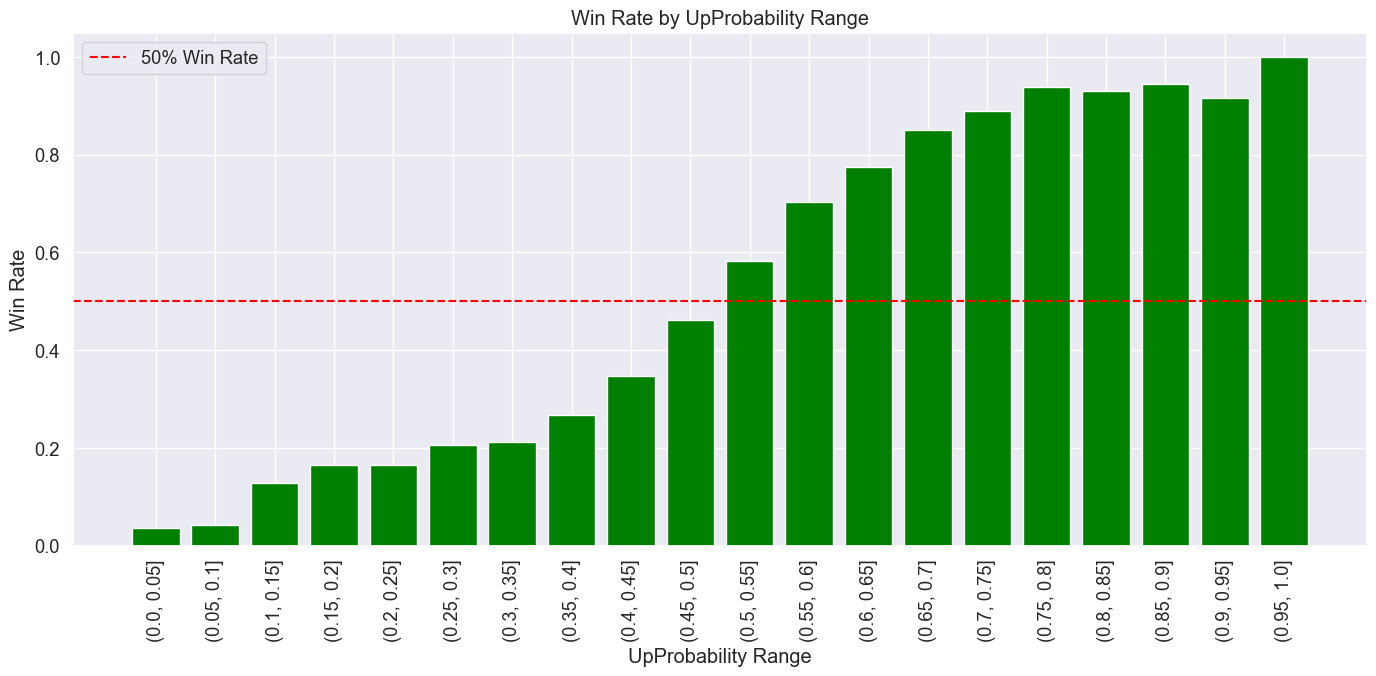

Calculating metrics: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

Variance Quantile Ranges:
  Variance_Quantile       min       max
0                Q1  0.001122  0.005395
1                Q2  0.005395  0.007674
2                Q3  0.007674  0.010868
3                Q4  0.010868  0.016960
4                Q5  0.016960  0.087900


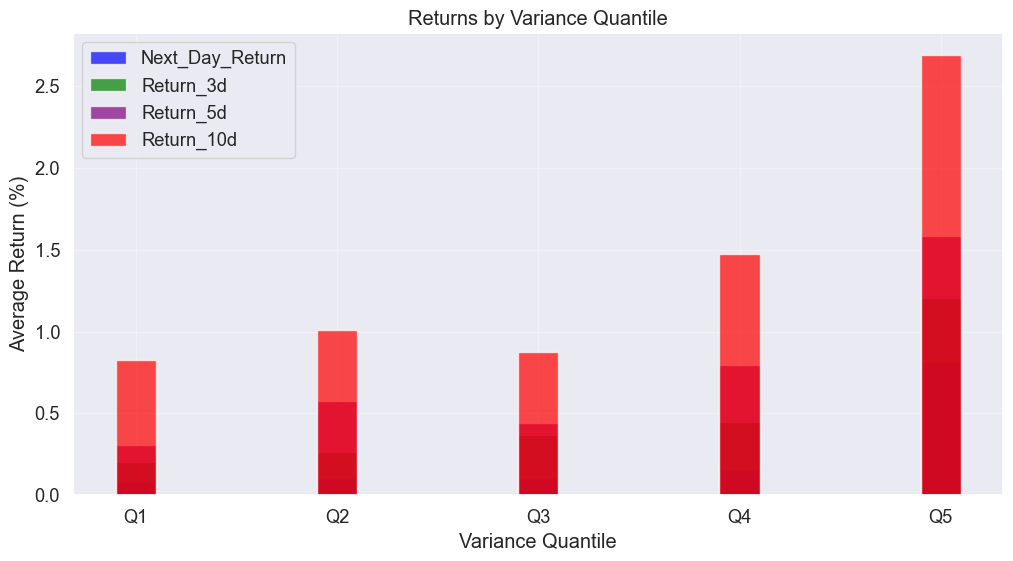

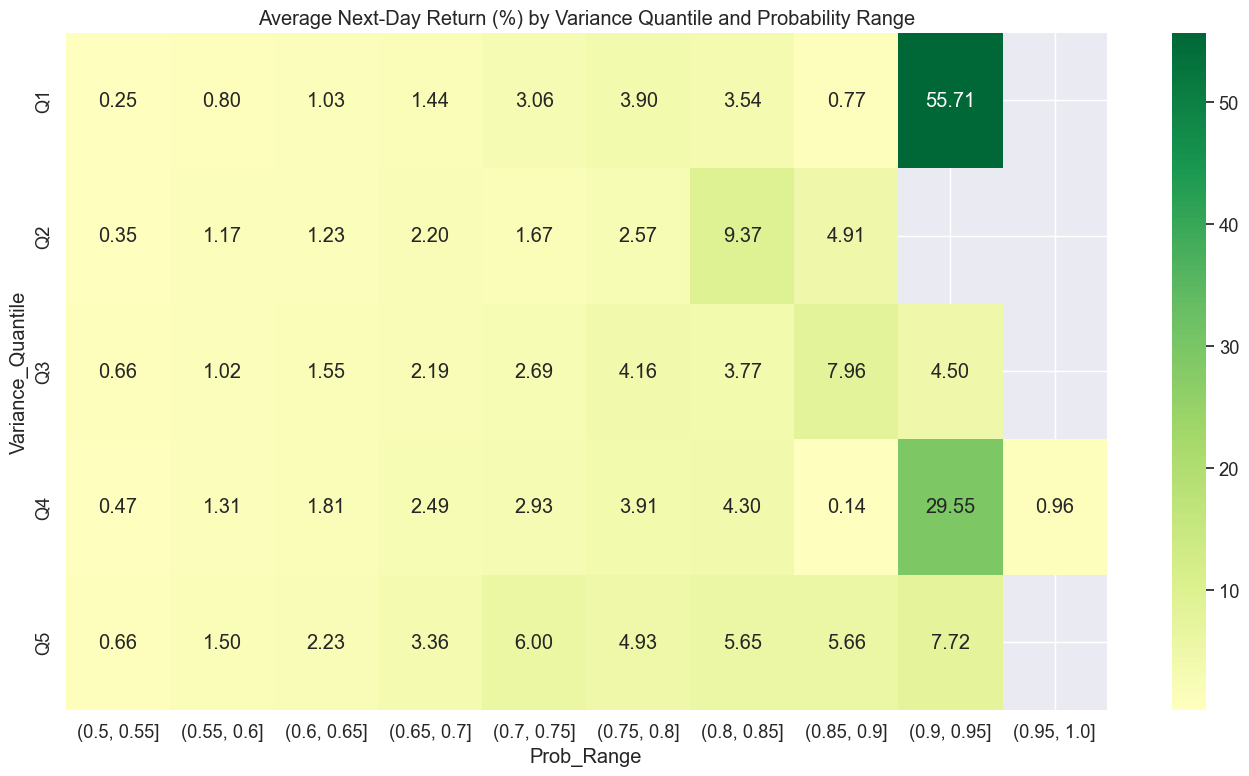

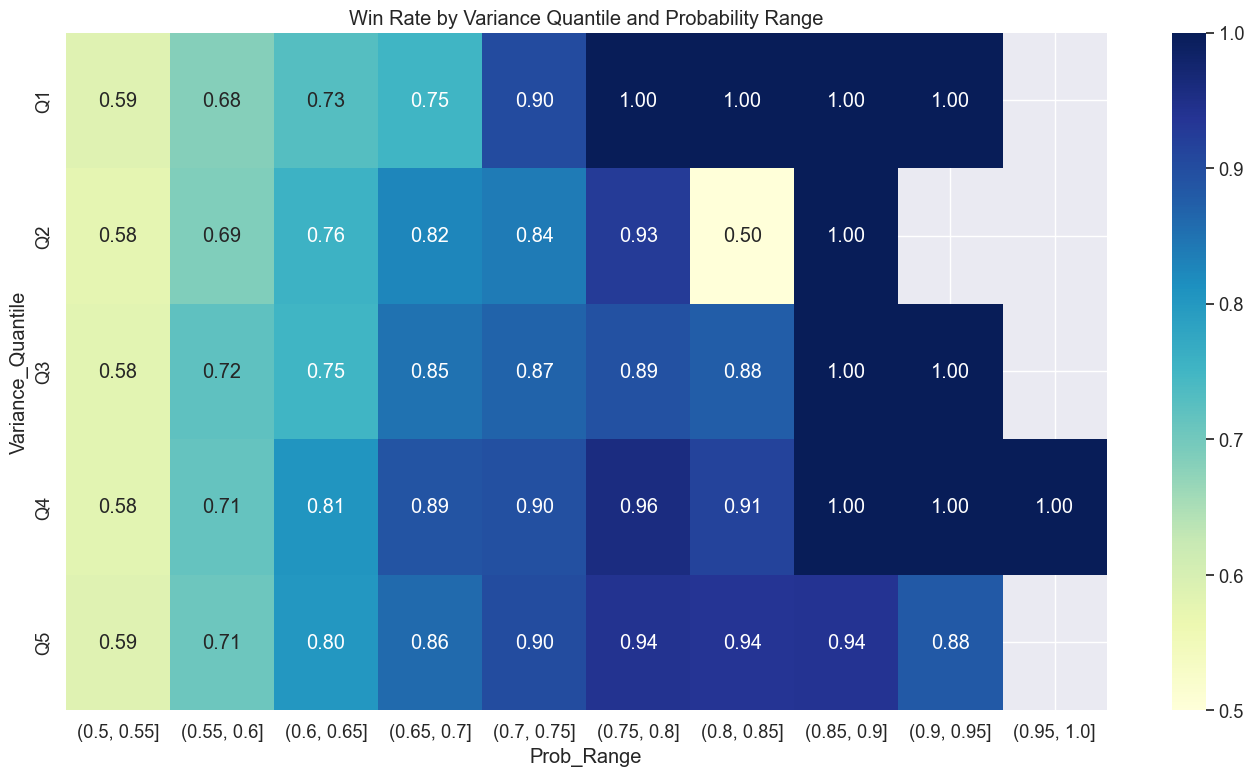

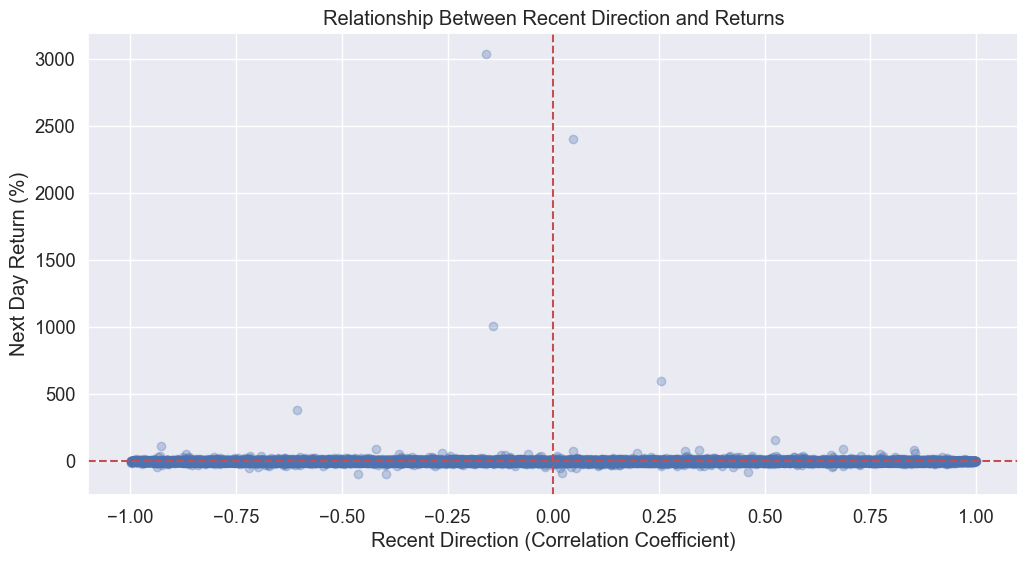

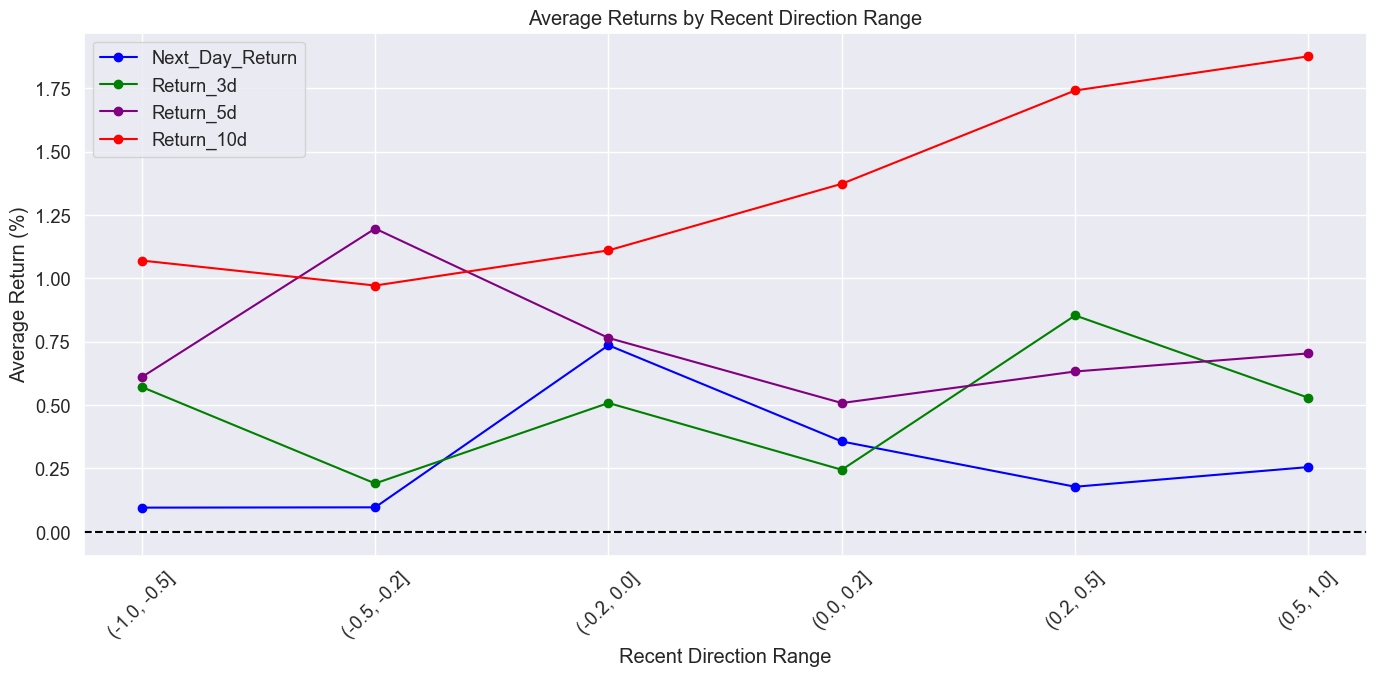

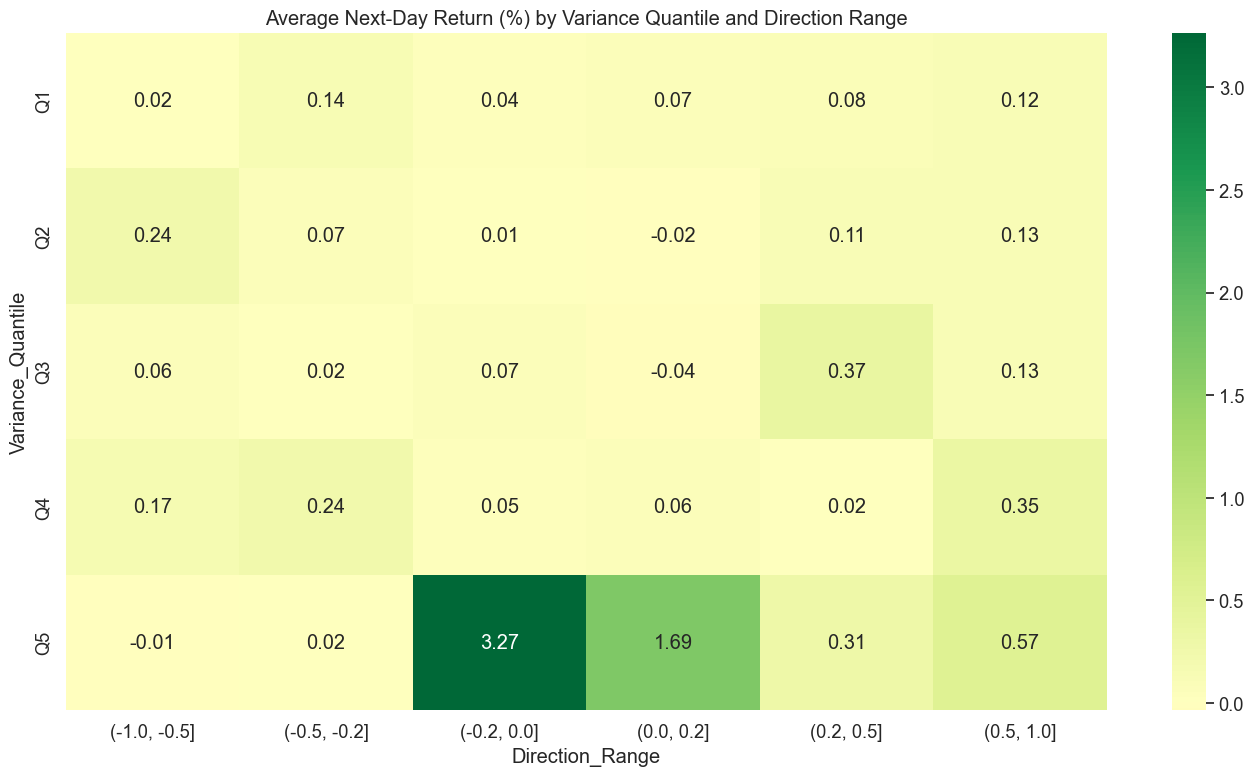

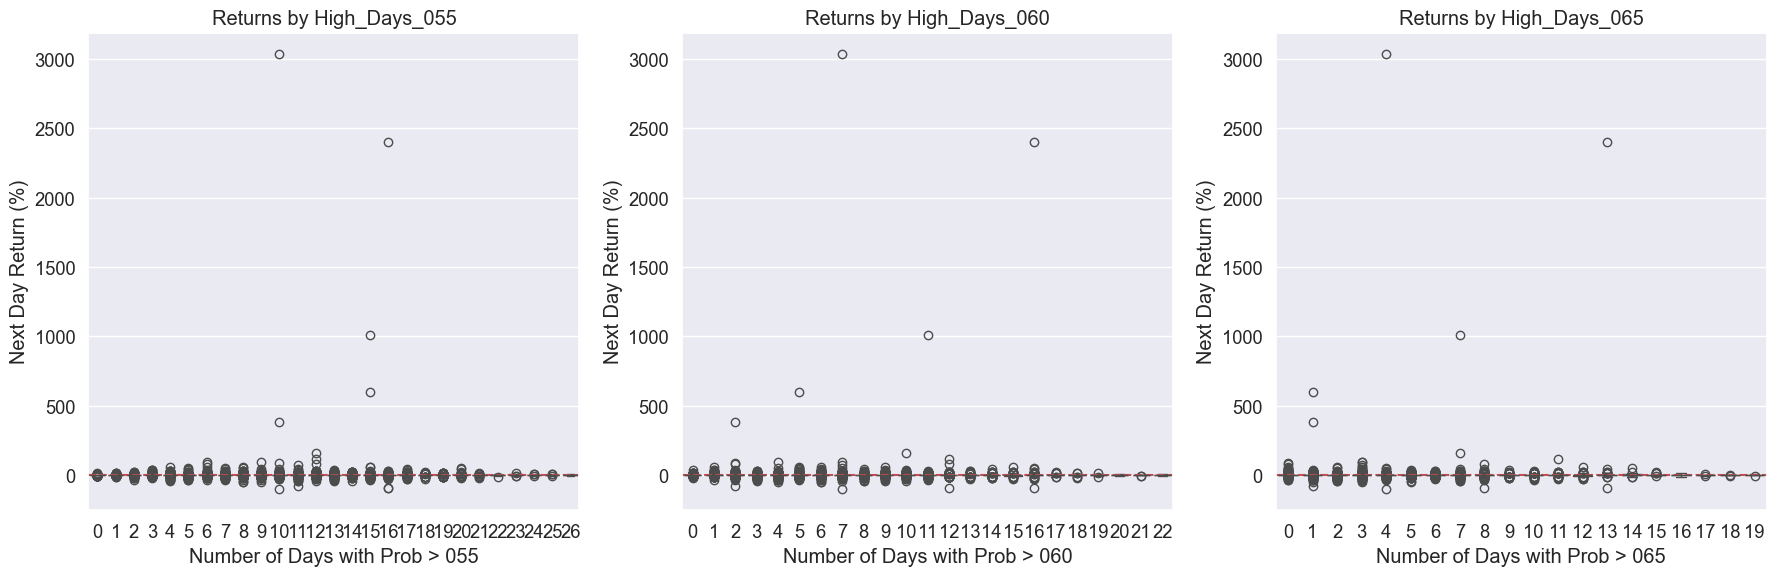

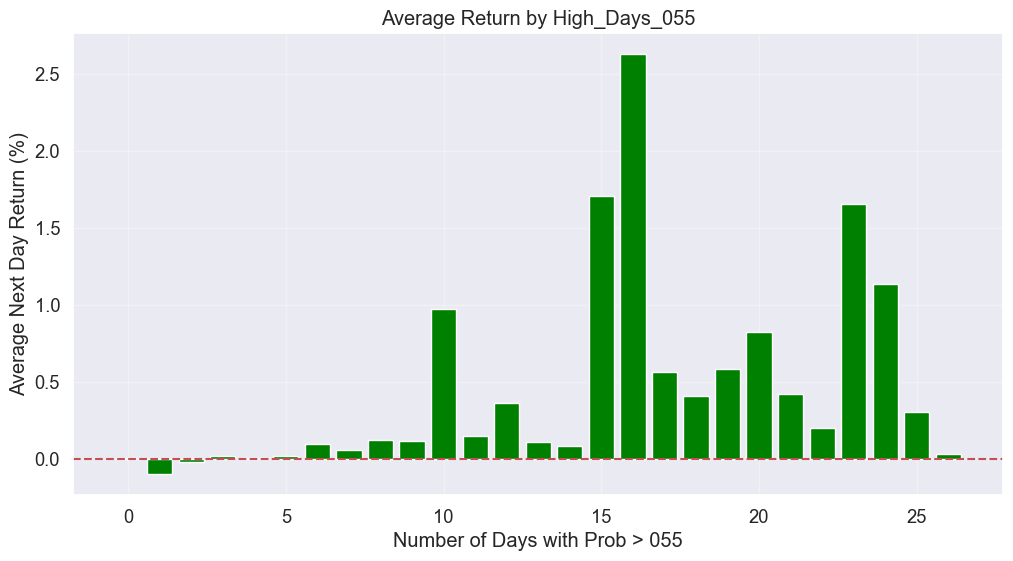

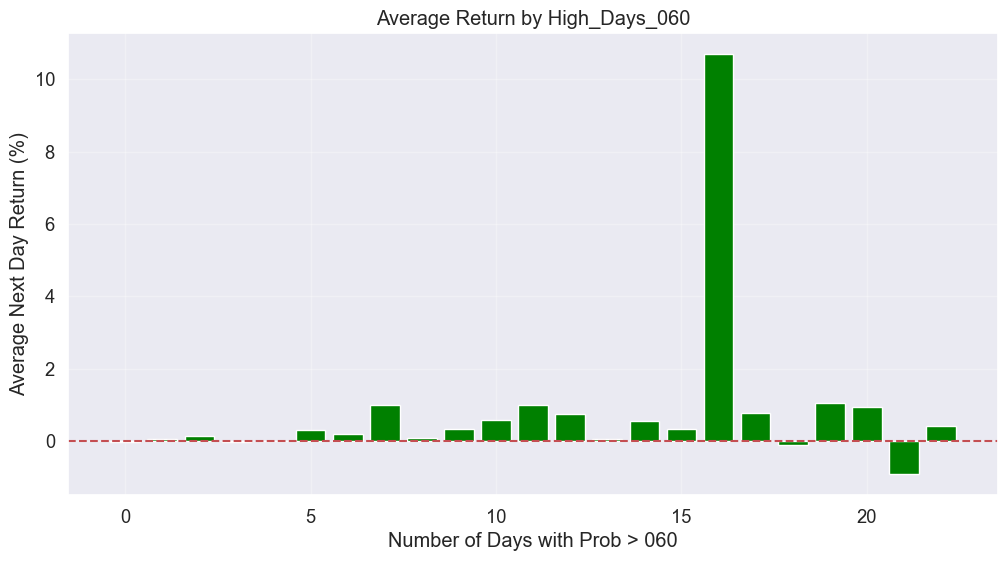

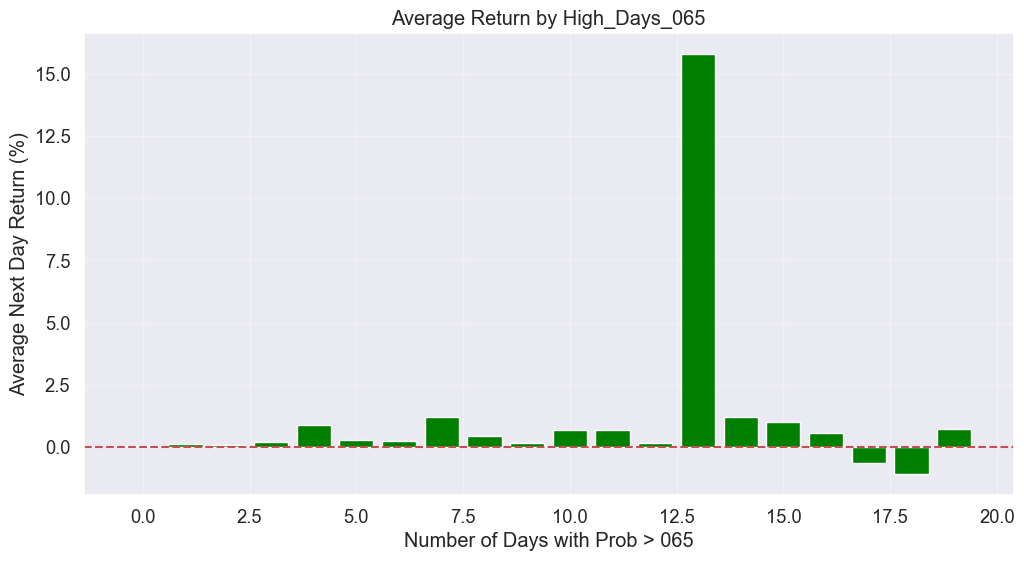

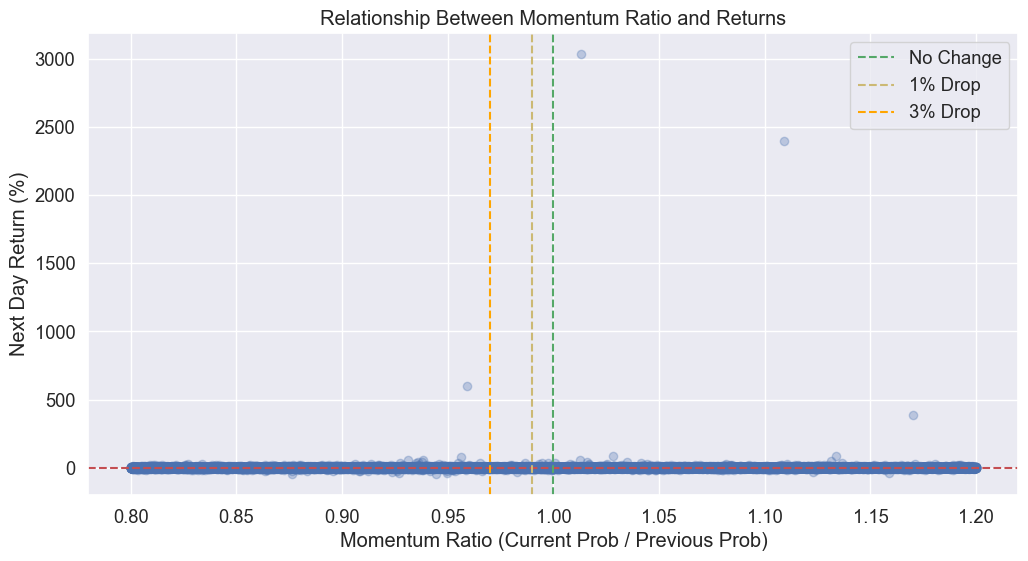

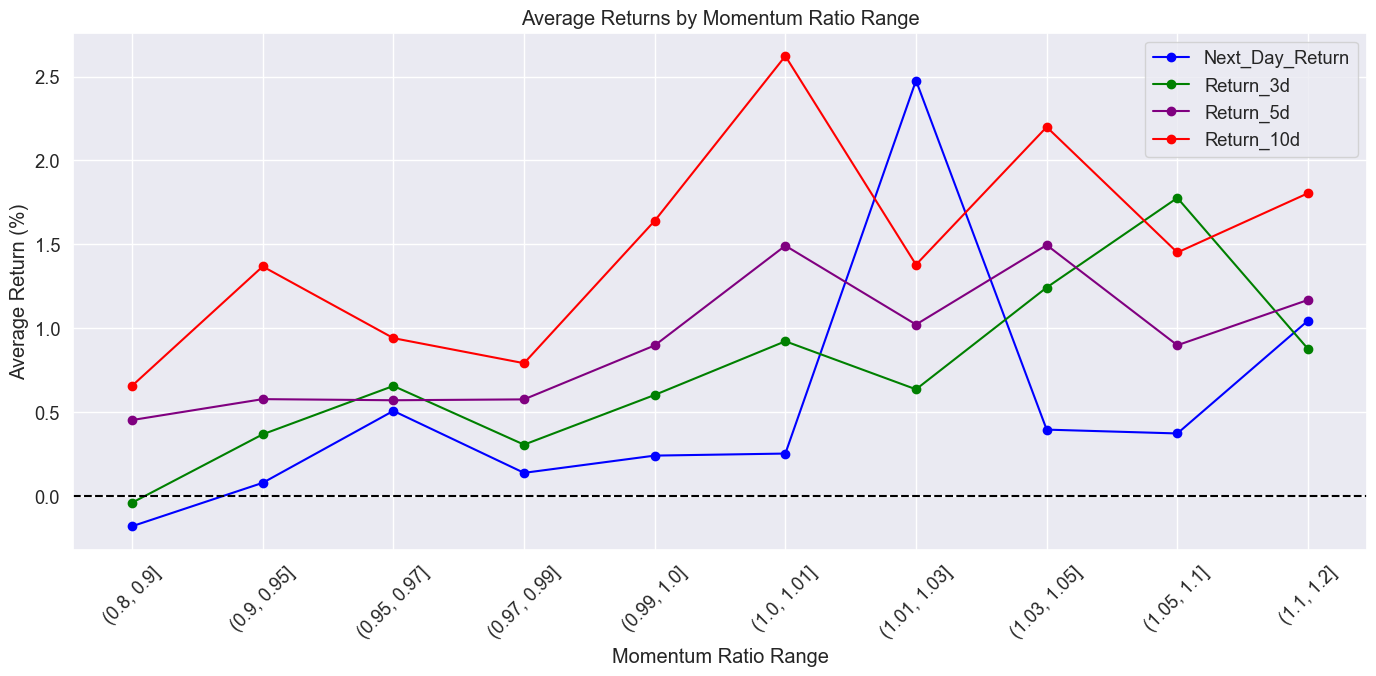

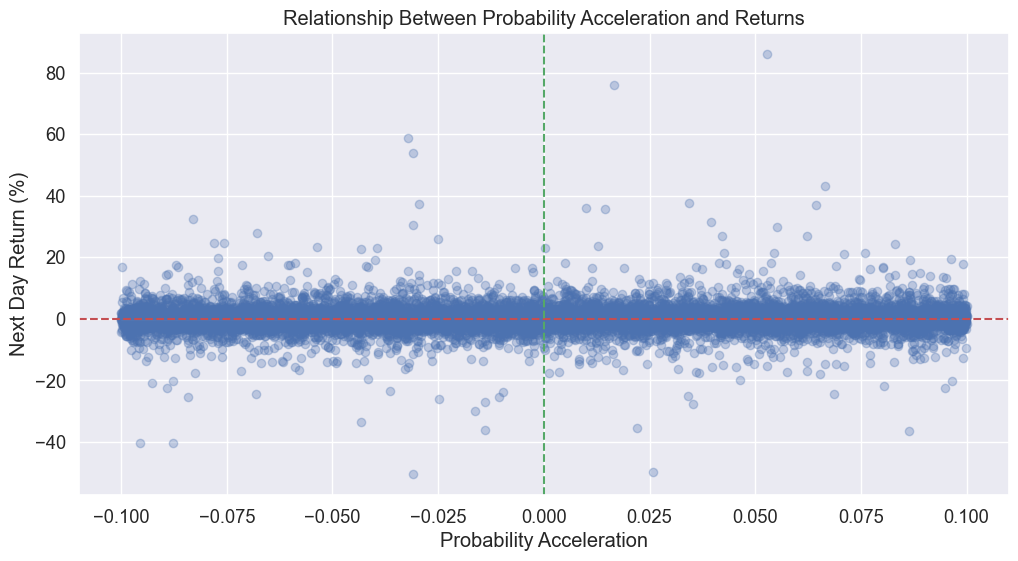

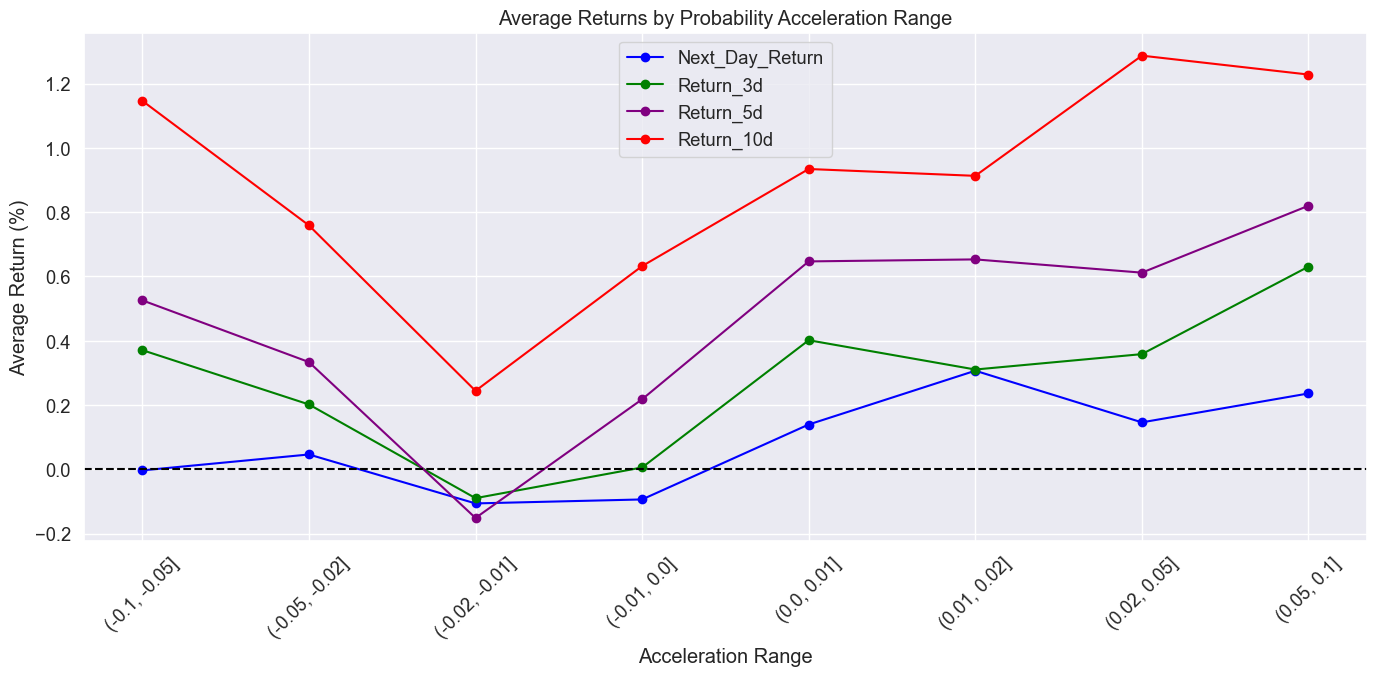

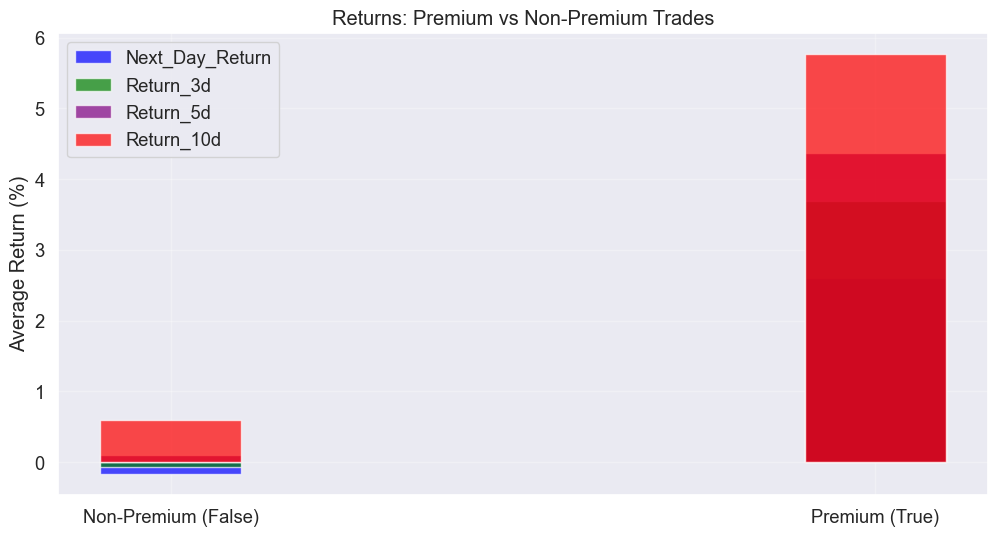

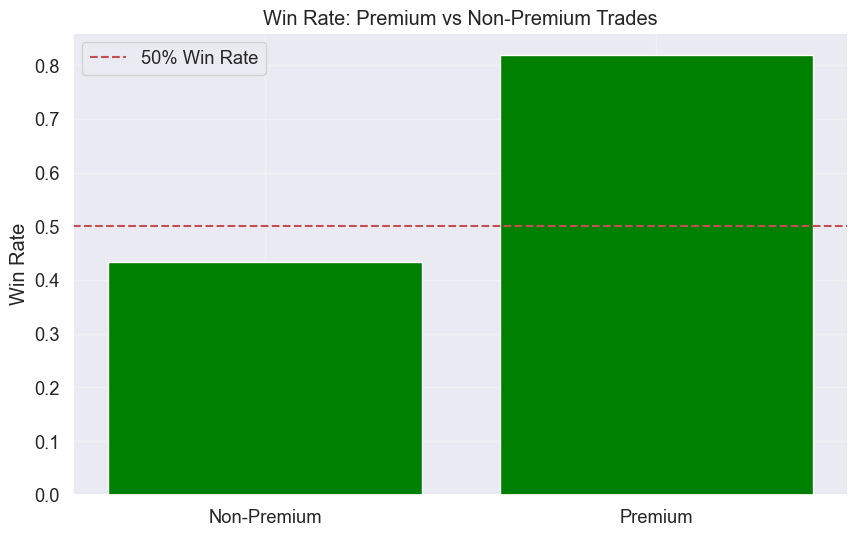

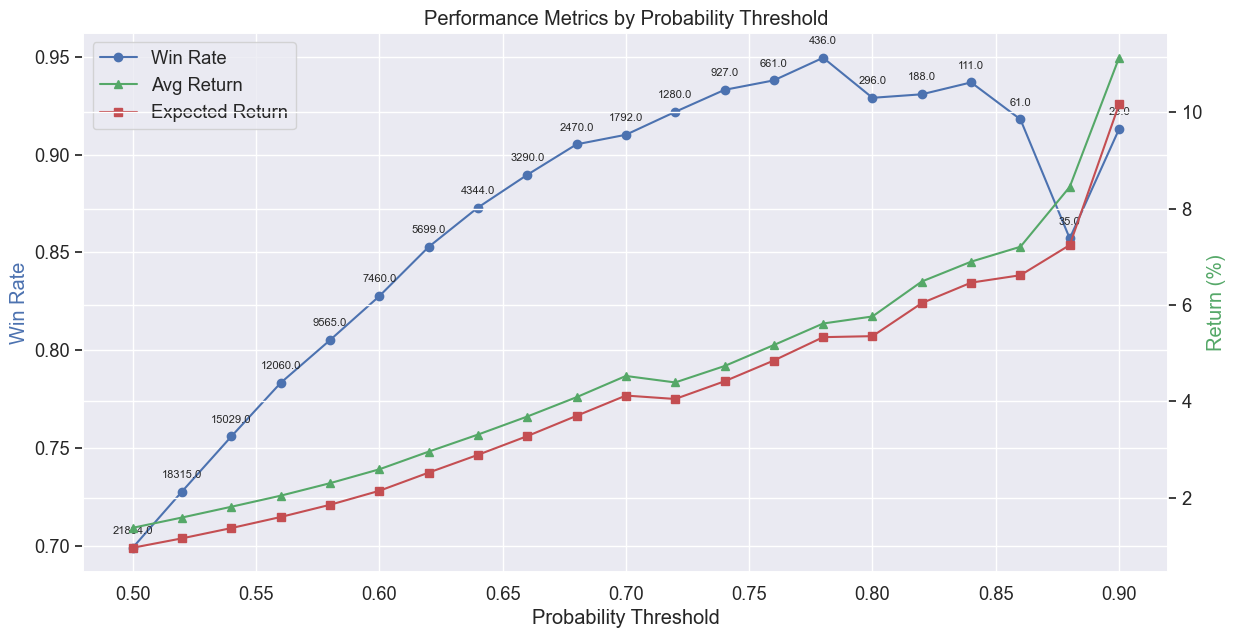

Top 10 Combinations by Expected Return:
           Filter_Type  Variance_Threshold  Probability_Threshold  Win_Rate  \
63   High_Var_Med_Prob              0.0050                    0.9  0.935897   
8    High_Var_Med_Prob              0.0005                    0.9  0.935897   
49   High_Var_Med_Prob              0.0025                    0.9  0.935897   
37   High_Var_Med_Prob              0.0020                    0.9  0.935897   
26   High_Var_Med_Prob              0.0015                    0.9  0.935897   
17   High_Var_Med_Prob              0.0010                    0.9  0.935897   
126  High_Var_Med_Prob              0.0200                    0.9  0.938462   
110  High_Var_Med_Prob              0.0150                    0.9  0.927536   
94   High_Var_Med_Prob              0.0100                    0.9  0.928571   
78   High_Var_Med_Prob              0.0075                    0.9  0.931507   

     Avg_Return  Count  Expected_Return  
63     7.139466     78         6.681808  
8     

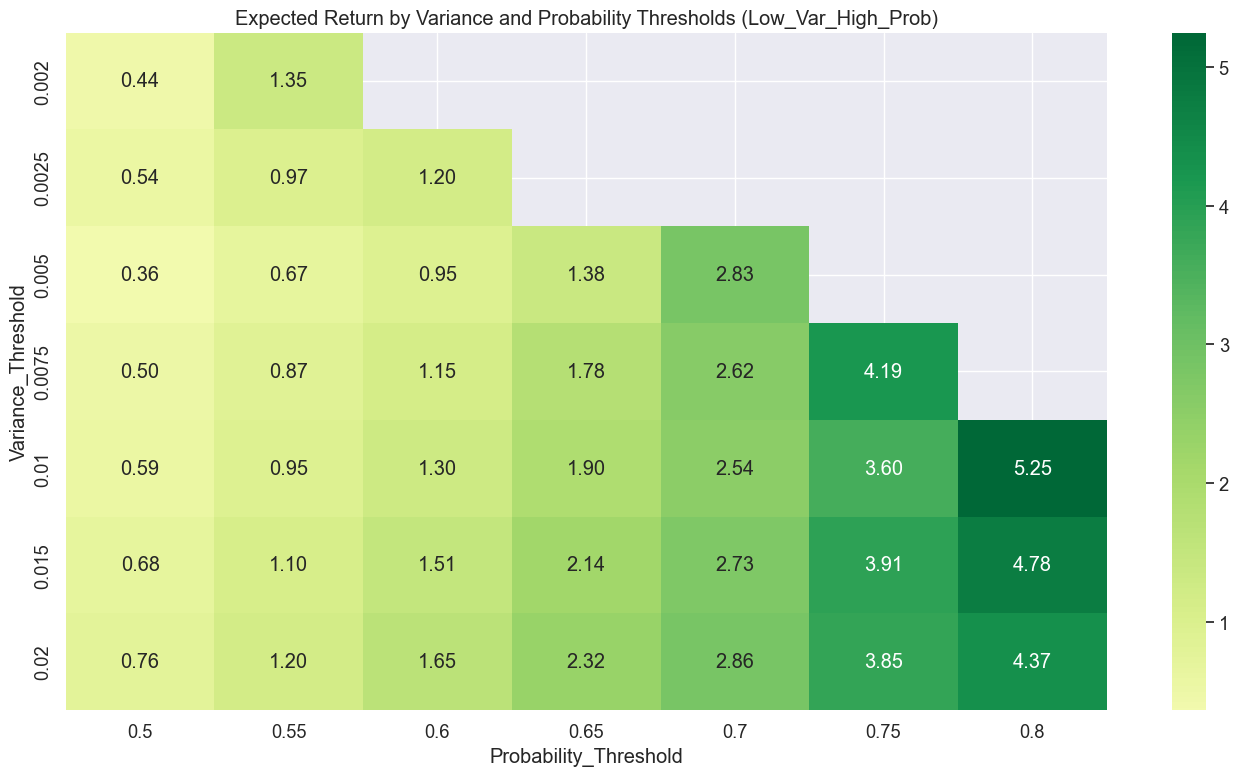

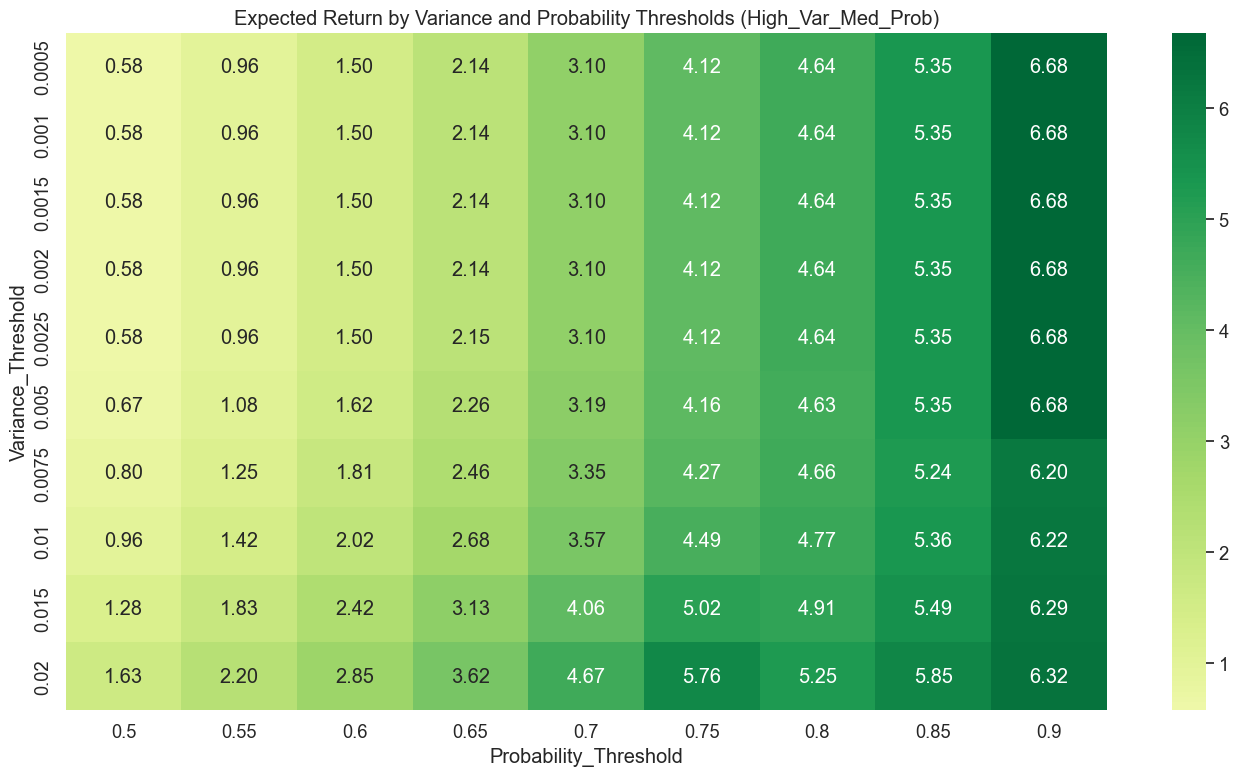

Top 10 Premium Trade Criteria:
    Min_Variance  Min_Probability  Win_Rate  Avg_Return  Count  \
34        0.0050             0.85  0.935897    7.139466     78   
27        0.0040             0.85  0.935897    7.139466     78   
20        0.0030             0.85  0.935897    7.139466     78   
13        0.0025             0.85  0.935897    7.139466     78   
6         0.0020             0.85  0.935897    7.139466     78   
62        0.0200             0.85  0.938462    6.735238     65   
55        0.0150             0.85  0.927536    6.778962     69   
48        0.0100             0.85  0.928571    6.695856     70   
41        0.0075             0.85  0.931507    6.652935     73   
61        0.0200             0.80  0.945000    6.185458    200   

    Expected_Return  
34         6.681808  
27         6.681808  
20         6.681808  
13         6.681808  
6          6.681808  
62         6.320762  
55         6.287733  
48         6.217580  
41         6.197255  
61         5.845258  


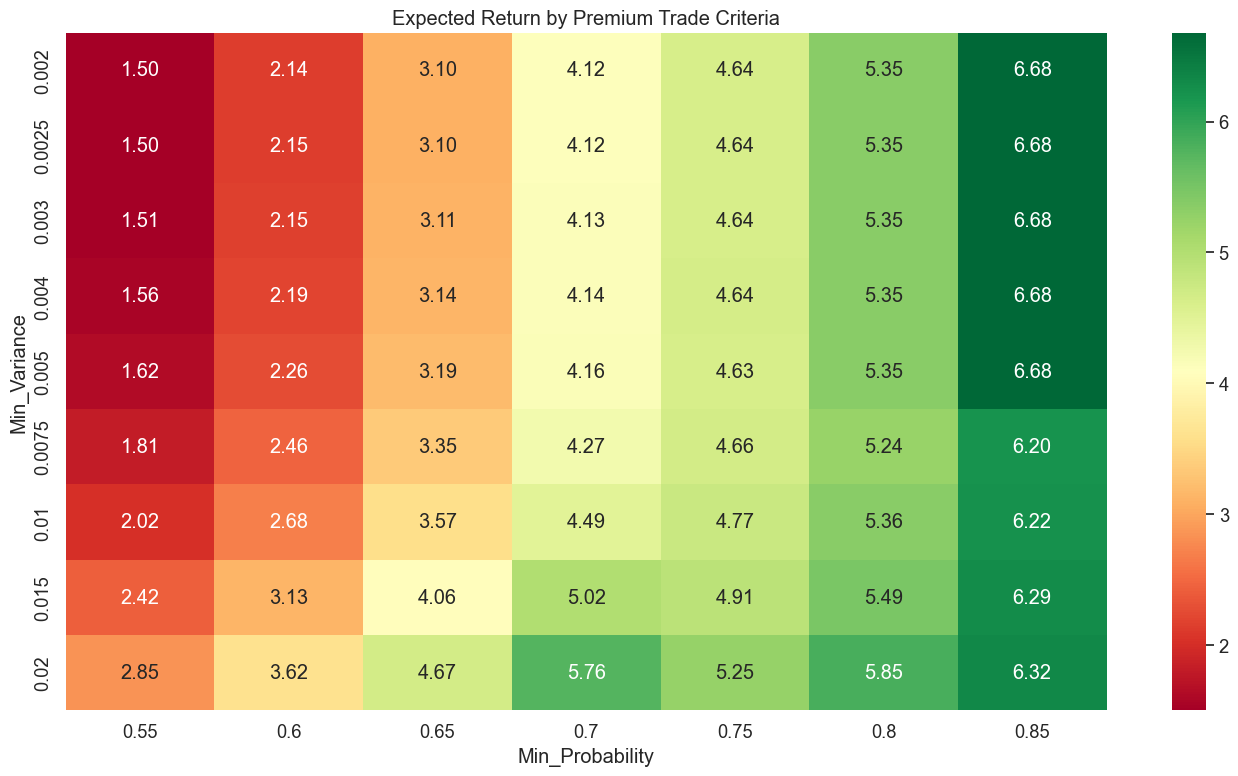

Final Recommendations (placeholder - to be updated based on analysis):
{
    "Variance Quantile Thresholds": {
        "Q1 (very low variance)": {
            "min_variance": 0.0,
            "max_variance": 0.001,
            "min_probability": 0.0
        },
        "Q2 (low variance)": {
            "min_variance": 0.001,
            "max_variance": 0.0015,
            "min_probability": 0.0
        },
        "Q3 (medium variance)": {
            "min_variance": 0.0015,
            "max_variance": 0.0025,
            "min_probability": 0.0
        },
        "Q4 (medium-high variance)": {
            "min_variance": 0.0025,
            "max_variance": 0.0075,
            "min_probability": 0.0
        },
        "Q5 (high variance)": {
            "min_variance": 0.0075,
            "max_variance": Infinity,
            "min_probability": 0.0
        }
    },
    "Premium Trade Criteria": {
        "Criterion 1": {
            "min_variance": 0.0025,
            "min_probability": 

In [11]:

import os
import glob
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

def load_sample_data(max_files=100):
    """
    Load data files with UpProbability values
    """
    data_folder = "Data/RFpredictions"
    file_paths = glob.glob(os.path.join(data_folder, "*.parquet"))
    
    if max_files:
        file_paths = file_paths[:max_files]
        
    print(f"Found {len(file_paths)} parquet files")
    
    # Load the data
    stock_data = []
    
    print("Starting to load files...")
    for i, file_path in enumerate(tqdm(file_paths, desc="Loading Files")):
        try:
            table = pq.read_table(file_path)
            df = table.to_pandas()
            
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date')
            
            ticker = os.path.basename(file_path).replace('.parquet', '')
            
            if len(df) > 30:  # Need at least 30 days for analysis
                df['Ticker'] = ticker
                stock_data.append(df)
                
                if (i+1) % 20 == 0:
                    print(f"Loaded {i+1} files so far, latest: {ticker}")
            
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            
    print(f"Successfully loaded data for {len(stock_data)} stocks")
    
    # Combine all data
    if not stock_data:
        raise ValueError("No valid stock data loaded")
        
    combined_df = pd.concat(stock_data, ignore_index=True)
    print(f"Combined dataset has {len(combined_df)} rows and covers {combined_df['Ticker'].nunique()} stocks")
    
    return combined_df

# Load data
combined_df = load_sample_data(max_files=100)  # Adjust as needed

# Calculate returns for different periods
combined_df['Next_Day_Return'] = combined_df.groupby('Ticker')['Close'].pct_change(-1) * 100
combined_df['Return_3d'] = combined_df.groupby('Ticker')['Close'].pct_change(-3) * 100
combined_df['Return_5d'] = combined_df.groupby('Ticker')['Close'].pct_change(-5) * 100
combined_df['Return_10d'] = combined_df.groupby('Ticker')['Close'].pct_change(-10) * 100

# Drop rows with missing returns or UpProbability
combined_df = combined_df.dropna(subset=['UpProbability', 'Next_Day_Return'])

# Display sample data
combined_df.head()

# Examine the distribution of UpProbability values
plt.figure(figsize=(14, 7))
sns.histplot(combined_df['UpProbability'], bins=50, kde=True)
plt.title('Distribution of UpProbability Values')
plt.xlabel('UpProbability')
plt.axvline(0.5, color='r', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.show()

# Descriptive statistics of UpProbability
print("Basic statistics of UpProbability:")
print(combined_df['UpProbability'].describe())

# Calculate performance metrics by probability range
prob_bins = np.arange(0, 1.05, 0.05)
combined_df['ProbabilityBin'] = pd.cut(combined_df['UpProbability'], bins=prob_bins)

returns_by_prob = combined_df.groupby('ProbabilityBin')[
    ['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d']
].mean().reset_index()

# Plot average returns by probability bin
plt.figure(figsize=(14, 7))
for col, color in zip(['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d'], 
                      ['blue', 'green', 'purple', 'red']):
    plt.plot(range(len(returns_by_prob)), returns_by_prob[col], marker='o', label=col, color=color)

plt.title('Average Returns by UpProbability Range')
plt.xlabel('UpProbability Range')
plt.ylabel('Average Return (%)')
plt.xticks(range(len(returns_by_prob)), [str(x) for x in returns_by_prob['ProbabilityBin']], rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate win rate (% of positive returns) by probability range
combined_df['Win'] = (combined_df['Next_Day_Return'] > 0).astype(int)
win_rate_by_prob = combined_df.groupby('ProbabilityBin')['Win'].mean().reset_index()

plt.figure(figsize=(14, 7))
plt.bar(range(len(win_rate_by_prob)), win_rate_by_prob['Win'], color='green')
plt.title('Win Rate by UpProbability Range')
plt.xlabel('UpProbability Range')
plt.ylabel('Win Rate')
plt.xticks(range(len(win_rate_by_prob)), [str(x) for x in win_rate_by_prob['ProbabilityBin']], rotation=90)
plt.axhline(0.5, color='red', linestyle='--', label='50% Win Rate')
plt.legend()
plt.tight_layout()
plt.show()

# Function to calculate variance and other metrics for each symbol
def calculate_variance_metrics(group, lookback=30):
    ticker = group['Ticker'].iloc[0]
    results = []
    
    # Ensure the data is properly sorted by date
    group = group.sort_values('Date')
    
    for i in range(lookback, len(group)):
        # Current row
        current_row = group.iloc[i]
        
        # Get lookback window
        lookback_window = group.iloc[i-lookback:i]
        
        # Calculate variance of UpProbability
        prob_variance = lookback_window['UpProbability'].var()
        
        # Calculate recent direction (correlation coefficient over last 5 days)
        recent_window = lookback_window.iloc[-5:]
        indices = np.arange(5)
        if len(recent_window) == 5:
            recent_direction = np.corrcoef(indices, recent_window['UpProbability'])[0, 1]
        else:
            recent_direction = np.nan
        
        # Count high probability days
        high_threshold_055 = sum(lookback_window['UpProbability'] > 0.55)
        high_threshold_060 = sum(lookback_window['UpProbability'] > 0.60)
        high_threshold_065 = sum(lookback_window['UpProbability'] > 0.65)
        
        # Calculate momentum preservation
        if i > 0:
            momentum_ratio = current_row['UpProbability'] / group.iloc[i-1]['UpProbability']
        else:
            momentum_ratio = np.nan
        
        # Calculate probability acceleration (first diff vs second diff)
        if i > 2:
            first_diff = group.iloc[i]['UpProbability'] - group.iloc[i-1]['UpProbability']
            second_diff = group.iloc[i-1]['UpProbability'] - group.iloc[i-2]['UpProbability']
            acceleration = first_diff - second_diff
        else:
            acceleration = np.nan
        
        results.append({
            'Ticker': ticker,
            'Date': current_row['Date'],
            'UpProbability': current_row['UpProbability'],
            'Next_Day_Return': current_row['Next_Day_Return'],
            'Return_3d': current_row['Return_3d'],
            'Return_5d': current_row['Return_5d'],
            'Return_10d': current_row['Return_10d'],
            'Variance': prob_variance,
            'Recent_Direction': recent_direction,
            'High_Days_055': high_threshold_055,
            'High_Days_060': high_threshold_060,
            'High_Days_065': high_threshold_065,
            'Momentum_Ratio': momentum_ratio,
            'Probability_Acceleration': acceleration
        })
    
    return pd.DataFrame(results)

# Calculate metrics for each ticker
all_metrics = []
for ticker, group in tqdm(combined_df.groupby('Ticker'), desc="Calculating metrics"):
    if len(group) > 30:  # Need sufficient history
        ticker_metrics = calculate_variance_metrics(group)
        all_metrics.append(ticker_metrics)

metrics_df = pd.concat(all_metrics, ignore_index=True)
metrics_df = metrics_df.dropna()  # Remove rows with NaN values

# Display sample of the metrics data
metrics_df.head()

# Create variance quantiles
metrics_df['Variance_Quantile'] = pd.qcut(metrics_df['Variance'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

# Display variance quantile ranges
variance_quantiles = metrics_df.groupby('Variance_Quantile')['Variance'].agg(['min', 'max']).reset_index()
print("Variance Quantile Ranges:")
print(variance_quantiles)

# Calculate performance metrics by variance quantile
performance_by_var = metrics_df.groupby('Variance_Quantile')[
    ['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d']
].mean().reset_index()

plt.figure(figsize=(12, 6))
for col, color in zip(['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d'], 
                    ['blue', 'green', 'purple', 'red']):
    plt.bar(performance_by_var['Variance_Quantile'], performance_by_var[col], 
            alpha=0.7, label=col, color=color, width=0.2)

plt.title('Returns by Variance Quantile')
plt.xlabel('Variance Quantile')
plt.ylabel('Average Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Create heatmap of returns by variance quantile and probability range
# First, categorize by probability ranges
prob_ranges = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
metrics_df['Prob_Range'] = pd.cut(metrics_df['UpProbability'], prob_ranges)
metrics_df['Win'] = (metrics_df['Next_Day_Return'] > 0).astype(int)

# Create pivot table of returns
heatmap_data = metrics_df.pivot_table(
    values='Next_Day_Return', 
    index='Variance_Quantile',
    columns='Prob_Range',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title('Average Next-Day Return (%) by Variance Quantile and Probability Range')
plt.tight_layout()
plt.show()

# Create win rate heatmap
win_rate_data = metrics_df.pivot_table(
    values='Win', 
    index='Variance_Quantile',
    columns='Prob_Range',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(win_rate_data, annot=True, cmap='YlGnBu', vmin=0.5, vmax=1.0, fmt='.2f')
plt.title('Win Rate by Variance Quantile and Probability Range')
plt.tight_layout()
plt.show()

# Analyze the relationship between trend direction and returns
plt.figure(figsize=(12, 6))
sns.regplot(x='Recent_Direction', y='Next_Day_Return', data=metrics_df, scatter_kws={'alpha':0.3})
plt.title('Relationship Between Recent Direction and Returns')
plt.xlabel('Recent Direction (Correlation Coefficient)')
plt.ylabel('Next Day Return (%)')
plt.axhline(0, color='r', linestyle='--')
plt.axvline(0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Group by recent direction ranges and calculate average returns
direction_bins = [-1.0, -0.5, -0.2, 0, 0.2, 0.5, 1.0]
metrics_df['Direction_Range'] = pd.cut(metrics_df['Recent_Direction'], direction_bins)

direction_returns = metrics_df.groupby('Direction_Range')[
    ['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d']
].mean().reset_index()

plt.figure(figsize=(14, 7))
for col, color in zip(['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d'], 
                      ['blue', 'green', 'purple', 'red']):
    plt.plot(range(len(direction_returns)), direction_returns[col], marker='o', label=col, color=color)

plt.title('Average Returns by Recent Direction Range')
plt.xlabel('Recent Direction Range')
plt.ylabel('Average Return (%)')
plt.xticks(range(len(direction_returns)), [str(x) for x in direction_returns['Direction_Range']], rotation=45)
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# Create heatmap of returns by variance quantile and direction range
direction_heatmap = metrics_df.pivot_table(
    values='Next_Day_Return', 
    index='Variance_Quantile',
    columns='Direction_Range',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(direction_heatmap, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title('Average Next-Day Return (%) by Variance Quantile and Direction Range')
plt.tight_layout()
plt.show()

# Analyze relationship between number of high probability days and returns
high_days_columns = ['High_Days_055', 'High_Days_060', 'High_Days_065']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(high_days_columns):
    sns.boxplot(x=col, y='Next_Day_Return', data=metrics_df, ax=axes[i])
    axes[i].set_title(f'Returns by {col}')
    axes[i].set_xlabel(f'Number of Days with Prob > {col[-3:]}')
    axes[i].set_ylabel('Next Day Return (%)')
    axes[i].axhline(0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Calculate average returns by number of high days
for col in high_days_columns:
    high_days_returns = metrics_df.groupby(col)['Next_Day_Return'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.bar(high_days_returns[col], high_days_returns['Next_Day_Return'], color='green')
    plt.title(f'Average Return by {col}')
    plt.xlabel(f'Number of Days with Prob > {col[-3:]}')
    plt.ylabel('Average Next Day Return (%)')
    plt.axhline(0, color='r', linestyle='--')
    plt.grid(True, alpha=0.3)
    plt.show()

# Analyze relationship between momentum ratio and returns
plt.figure(figsize=(12, 6))
# Filter outliers for better visualization
filtered_df = metrics_df[(metrics_df['Momentum_Ratio'] > 0.8) & (metrics_df['Momentum_Ratio'] < 1.2)]
sns.regplot(x='Momentum_Ratio', y='Next_Day_Return', data=filtered_df, scatter_kws={'alpha':0.3})
plt.title('Relationship Between Momentum Ratio and Returns')
plt.xlabel('Momentum Ratio (Current Prob / Previous Prob)')
plt.ylabel('Next Day Return (%)')
plt.axhline(0, color='r', linestyle='--')
plt.axvline(1.0, color='g', linestyle='--', label='No Change')
plt.axvline(0.99, color='y', linestyle='--', label='1% Drop')
plt.axvline(0.97, color='orange', linestyle='--', label='3% Drop')
plt.legend()
plt.grid(True)
plt.show()

# Group by momentum ratio ranges and calculate average returns
momentum_bins = [0.8, 0.9, 0.95, 0.97, 0.99, 1.0, 1.01, 1.03, 1.05, 1.1, 1.2]
filtered_df['Momentum_Range'] = pd.cut(filtered_df['Momentum_Ratio'], momentum_bins)

momentum_returns = filtered_df.groupby('Momentum_Range')[
    ['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d', 'UpProbability']
].mean().reset_index()

plt.figure(figsize=(14, 7))
for col, color in zip(['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d'], 
                      ['blue', 'green', 'purple', 'red']):
    plt.plot(range(len(momentum_returns)), momentum_returns[col], marker='o', label=col, color=color)

plt.title('Average Returns by Momentum Ratio Range')
plt.xlabel('Momentum Ratio Range')
plt.ylabel('Average Return (%)')
plt.xticks(range(len(momentum_returns)), [str(x) for x in momentum_returns['Momentum_Range']], rotation=45)
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# Analyze relationship between probability acceleration and returns
plt.figure(figsize=(12, 6))
# Filter outliers for better visualization
accel_filtered_df = metrics_df[(metrics_df['Probability_Acceleration'] > -0.1) & 
                              (metrics_df['Probability_Acceleration'] < 0.1)]
sns.regplot(x='Probability_Acceleration', y='Next_Day_Return', data=accel_filtered_df, scatter_kws={'alpha':0.3})
plt.title('Relationship Between Probability Acceleration and Returns')
plt.xlabel('Probability Acceleration')
plt.ylabel('Next Day Return (%)')
plt.axhline(0, color='r', linestyle='--')
plt.axvline(0, color='g', linestyle='--')
plt.grid(True)
plt.show()

# Group by acceleration ranges and calculate average returns
accel_bins = [-0.1, -0.05, -0.02, -0.01, 0, 0.01, 0.02, 0.05, 0.1]
accel_filtered_df['Acceleration_Range'] = pd.cut(accel_filtered_df['Probability_Acceleration'], accel_bins)

accel_returns = accel_filtered_df.groupby('Acceleration_Range')[
    ['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d']
].mean().reset_index()

plt.figure(figsize=(14, 7))
for col, color in zip(['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d'], 
                      ['blue', 'green', 'purple', 'red']):
    plt.plot(range(len(accel_returns)), accel_returns[col], marker='o', label=col, color=color)

plt.title('Average Returns by Probability Acceleration Range')
plt.xlabel('Acceleration Range')
plt.ylabel('Average Return (%)')
plt.xticks(range(len(accel_returns)), [str(x) for x in accel_returns['Acceleration_Range']], rotation=45)
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# Replicate the premium trade identification logic from your function
def is_premium_trade(row):
    if row['Variance'] > 0.0025 and row['UpProbability'] > 0.65:
        return True
    elif row['Variance'] > 0.0075 and row['UpProbability'] > 0.60:
        return True
    elif row['Variance'] > 0.015 and row['UpProbability'] > 0.55:
        return True
    else:
        return False

metrics_df['Is_Premium'] = metrics_df.apply(is_premium_trade, axis=1)

# Compare returns between premium and non-premium trades
premium_comparison = metrics_df.groupby('Is_Premium')[
    ['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d']
].mean().reset_index()

plt.figure(figsize=(12, 6))
for col, color in zip(['Next_Day_Return', 'Return_3d', 'Return_5d', 'Return_10d'], 
                     ['blue', 'green', 'purple', 'red']):
    plt.bar([f"Non-Premium ({premium_comparison.iloc[0]['Is_Premium']})", 
             f"Premium ({premium_comparison.iloc[1]['Is_Premium']})"],
           premium_comparison[col], alpha=0.7, label=col, color=color, width=0.2)

plt.title('Returns: Premium vs Non-Premium Trades')
plt.ylabel('Average Return (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Calculate win rate for premium vs non-premium trades
metrics_df['Win'] = (metrics_df['Next_Day_Return'] > 0).astype(int)
premium_win_rate = metrics_df.groupby('Is_Premium')['Win'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(['Non-Premium', 'Premium'], premium_win_rate['Win'], color='green')
plt.title('Win Rate: Premium vs Non-Premium Trades')
plt.ylabel('Win Rate')
plt.axhline(0.5, color='r', linestyle='--', label='50% Win Rate')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Test different probability thresholds to find optimal values for your new model
thresholds = np.arange(0.5, 1.0, 0.02)
results = []

for thresh in thresholds:
    filtered_data = metrics_df[metrics_df['UpProbability'] >= thresh]
    if len(filtered_data) > 20:  # Ensure sufficient sample size
        win_rate = (filtered_data['Next_Day_Return'] > 0).mean()
        avg_return = filtered_data['Next_Day_Return'].mean()
        count = len(filtered_data)
        
        results.append({
            'Threshold': thresh,
            'Win_Rate': win_rate,
            'Avg_Return': avg_return,
            'Count': count,
            'Expected_Return': win_rate * avg_return  # Simple expected value
        })

results_df = pd.DataFrame(results)

plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

line1 = ax1.plot(results_df['Threshold'], results_df['Win_Rate'], 'b-o', label='Win Rate')
line2 = ax2.plot(results_df['Threshold'], results_df['Avg_Return'], 'g-^', label='Avg Return')
line3 = ax2.plot(results_df['Threshold'], results_df['Expected_Return'], 'r-s', label='Expected Return')

ax1.set_xlabel('Probability Threshold')
ax1.set_ylabel('Win Rate', color='b')
ax2.set_ylabel('Return (%)', color='g')

# Add count annotations
for i, row in results_df.iterrows():
    ax1.annotate(f"{row['Count']}", (row['Threshold'], row['Win_Rate']), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Add all lines to the legend
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title('Performance Metrics by Probability Threshold')
plt.grid(True)
plt.show()

# Test optimal combinations of probability threshold and variance
variance_thresholds = [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02]
prob_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

combination_results = []

for var_thresh in variance_thresholds:
    for prob_thresh in prob_thresholds:
        # Low variance with high probability
        low_var_high_prob = metrics_df[(metrics_df['Variance'] < var_thresh) & 
                                       (metrics_df['UpProbability'] >= prob_thresh)]
        
        # High variance with medium probability
        high_var_med_prob = metrics_df[(metrics_df['Variance'] >= var_thresh) & 
                                       (metrics_df['UpProbability'] >= (prob_thresh - 0.05))]
        
        for filter_type, filtered_data in [("Low_Var_High_Prob", low_var_high_prob), 
                                          ("High_Var_Med_Prob", high_var_med_prob)]:
            if len(filtered_data) > 20:  # Ensure sufficient sample size
                win_rate = (filtered_data['Next_Day_Return'] > 0).mean()
                avg_return = filtered_data['Next_Day_Return'].mean()
                count = len(filtered_data)
                
                combination_results.append({
                    'Filter_Type': filter_type,
                    'Variance_Threshold': var_thresh,
                    'Probability_Threshold': prob_thresh,
                    'Win_Rate': win_rate,
                    'Avg_Return': avg_return,
                    'Count': count,
                    'Expected_Return': win_rate * avg_return  # Simple expected value
                })

combination_df = pd.DataFrame(combination_results)

# Find top combinations by expected return
top_combinations = combination_df.sort_values('Expected_Return', ascending=False).head(10)
print("Top 10 Combinations by Expected Return:")
print(top_combinations[['Filter_Type', 'Variance_Threshold', 'Probability_Threshold', 
                       'Win_Rate', 'Avg_Return', 'Count', 'Expected_Return']])

# Create heatmap of expected returns by probability and variance thresholds
for filter_type in ['Low_Var_High_Prob', 'High_Var_Med_Prob']:
    pivot_data = combination_df[combination_df['Filter_Type'] == filter_type].pivot_table(
        values='Expected_Return', 
        index='Variance_Threshold',
        columns='Probability_Threshold',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_data, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
    plt.title(f'Expected Return by Variance and Probability Thresholds ({filter_type})')
    plt.tight_layout()
    plt.show()

# Test different premium trade identification criteria
def test_premium_criteria(min_variance, min_probability, df):
    premium_trades = df[(df['Variance'] > min_variance) & (df['UpProbability'] > min_probability)]
    if len(premium_trades) < 20:
        return None
    
    win_rate = (premium_trades['Next_Day_Return'] > 0).mean()
    avg_return = premium_trades['Next_Day_Return'].mean()
    count = len(premium_trades)
    
    return {
        'Min_Variance': min_variance,
        'Min_Probability': min_probability,
        'Win_Rate': win_rate,
        'Avg_Return': avg_return,
        'Count': count,
        'Expected_Return': win_rate * avg_return
    }

# Test various combinations for premium trade identification
premium_variance_values = [0.002, 0.0025, 0.003, 0.004, 0.005, 0.0075, 0.01, 0.015, 0.02]
premium_prob_values = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

premium_criteria_results = []

for var_val in premium_variance_values:
    for prob_val in premium_prob_values:
        result = test_premium_criteria(var_val, prob_val, metrics_df)
        if result:
            premium_criteria_results.append(result)

premium_criteria_df = pd.DataFrame(premium_criteria_results)

# Find optimal premium trade criteria
top_premium_criteria = premium_criteria_df.sort_values('Expected_Return', ascending=False).head(10)
print("Top 10 Premium Trade Criteria:")
print(top_premium_criteria[['Min_Variance', 'Min_Probability', 
                           'Win_Rate', 'Avg_Return', 'Count', 'Expected_Return']])

# Create heatmap of expected returns by premium criteria
pivot_premium = premium_criteria_df.pivot_table(
    values='Expected_Return', 
    index='Min_Variance',
    columns='Min_Probability',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_premium, annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Expected Return by Premium Trade Criteria')
plt.tight_layout()
plt.show()

# Based on all analysis, create a new version of can_buy logic
def new_can_buy_recommendation(data):
    """
    This function recommends parameters for your can_buy function based on the analysis.
    
    The results are intended to be directly transferable to your trading strategy.
    """
    # Placeholder for recommendations (to be filled based on analysis results)
    recommendations = {
        'Variance Quantile Thresholds': {
            'Q1 (very low variance)': {'min_variance': 0.0, 'max_variance': 0.001, 'min_probability': 0.0},
            'Q2 (low variance)': {'min_variance': 0.001, 'max_variance': 0.0015, 'min_probability': 0.0},
            'Q3 (medium variance)': {'min_variance': 0.0015, 'max_variance': 0.0025, 'min_probability': 0.0},
            'Q4 (medium-high variance)': {'min_variance': 0.0025, 'max_variance': 0.0075, 'min_probability': 0.0},
            'Q5 (high variance)': {'min_variance': 0.0075, 'max_variance': float('inf'), 'min_probability': 0.0},
        },
        'Premium Trade Criteria': {
            'Criterion 1': {'min_variance': 0.0025, 'min_probability': 0.65},
            'Criterion 2': {'min_variance': 0.0075, 'min_probability': 0.6},
            'Criterion 3': {'min_variance': 0.015, 'min_probability': 0.55},
        },
        'Trend Requirements': {
            'Q1 (very low variance)': {'min_direction': 0.0},
            'Q2 (low variance)': {'min_direction': 0.0},
            'Q3-Q5 (medium to high variance)': {'min_direction': 0.0},
            'Premium Trades': {'min_direction': 0.0},
        },
        'Consistency Requirements': {
            'Q1-Q2 (low variance)': {'high_threshold': 0.0, 'min_high_days': 0},
            'Q3-Q5 (medium to high variance)': {'high_threshold': 0.0, 'min_high_days': 0},
            'Premium Trades': {'high_threshold': 0.0, 'min_high_days': 0},
        },
        'Momentum Requirements': {
            'Standard Trades': {'min_momentum_ratio': 0.0},
            'Premium Trades': {'min_momentum_ratio': 0.0},
        }
    }
    
    # These values will be updated based on analysis results
    return recommendations

# Create a placeholder for the recommendations - will be filled based on analysis results
final_recommendations = new_can_buy_recommendation(None)
print("Final Recommendations (placeholder - to be updated based on analysis):")
import json
print(json.dumps(final_recommendations, indent=4))




Found 4393 parquet files
Starting to load files...


Loading Files: 100%|██████████| 4393/4393 [00:07<00:00, 612.37it/s]


Successfully loaded data for 4393 stocks


Analyzing Predictions: 100%|██████████| 4393/4393 [00:35<00:00, 124.70it/s]


Combined dataset has 1102643 rows and covers 4393 stocks


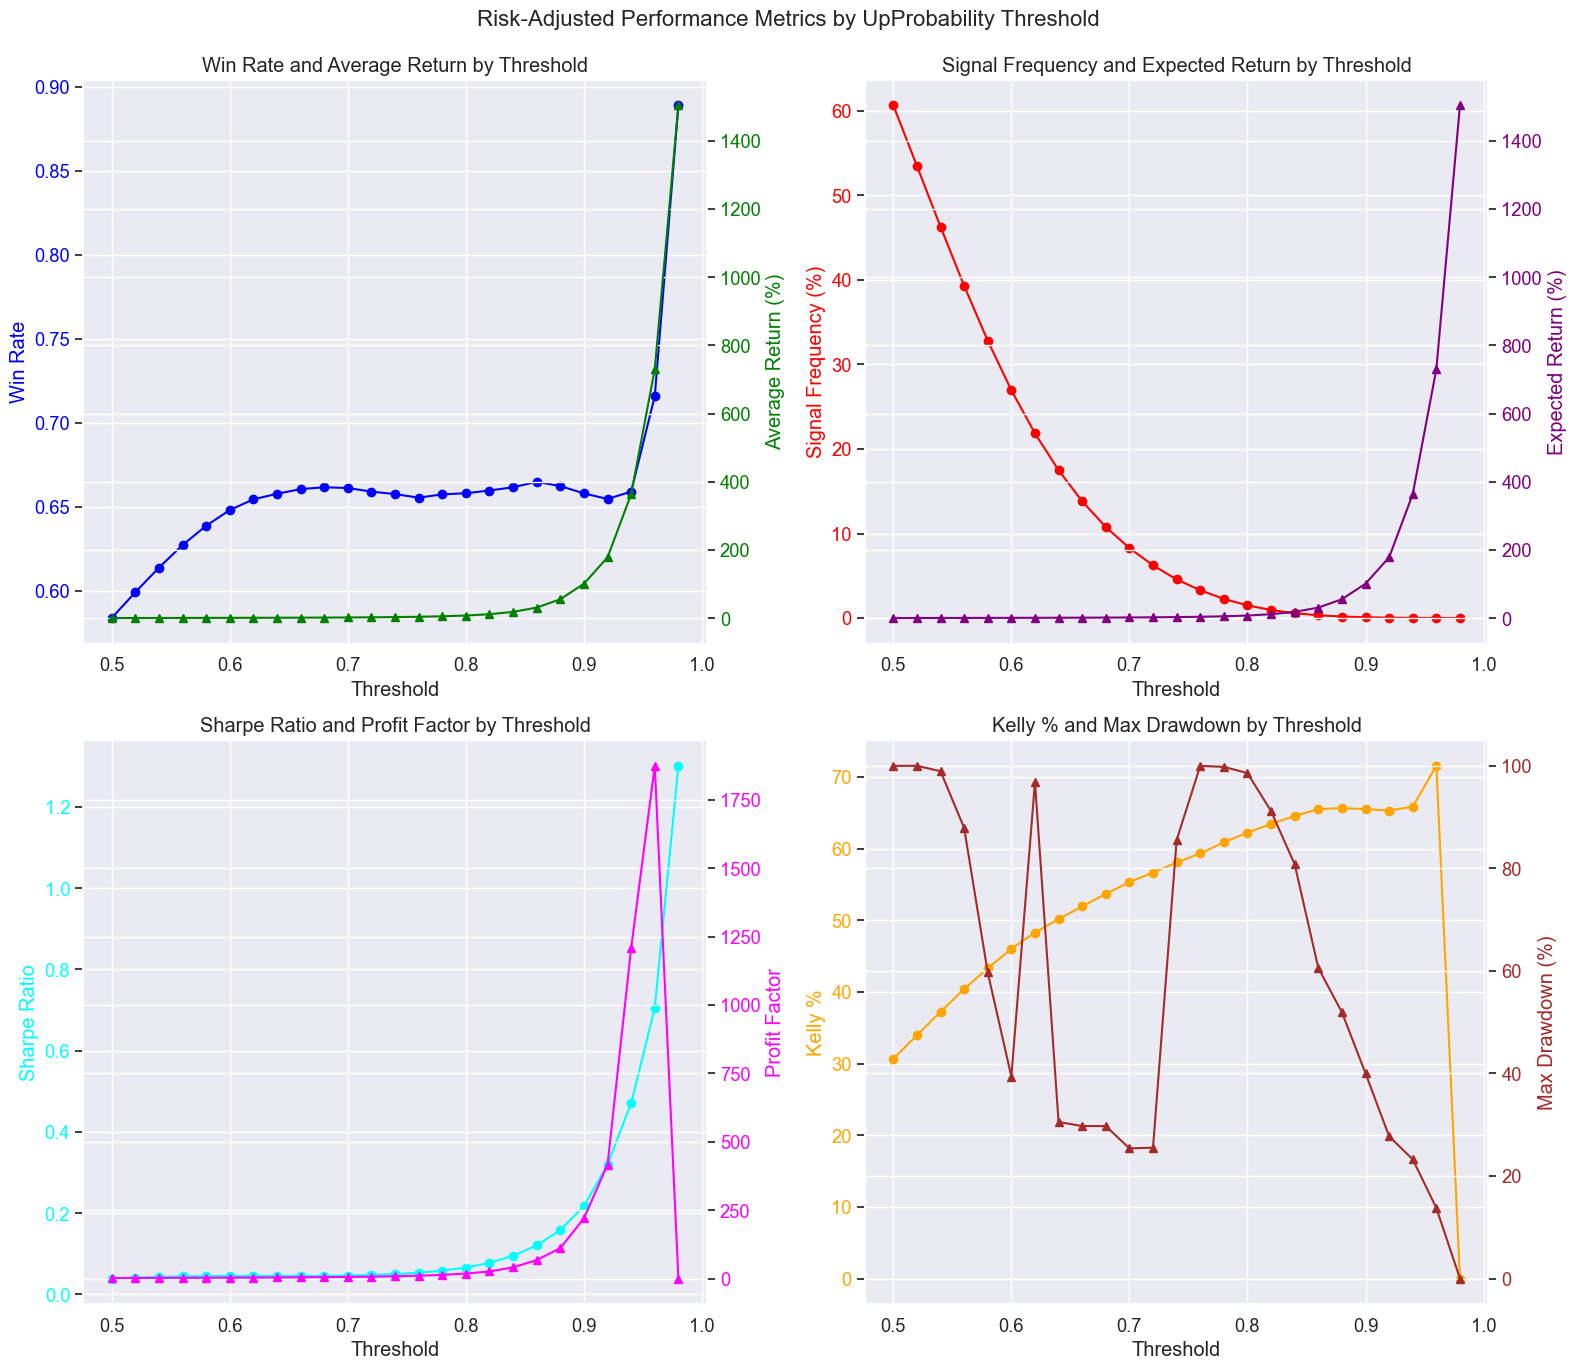

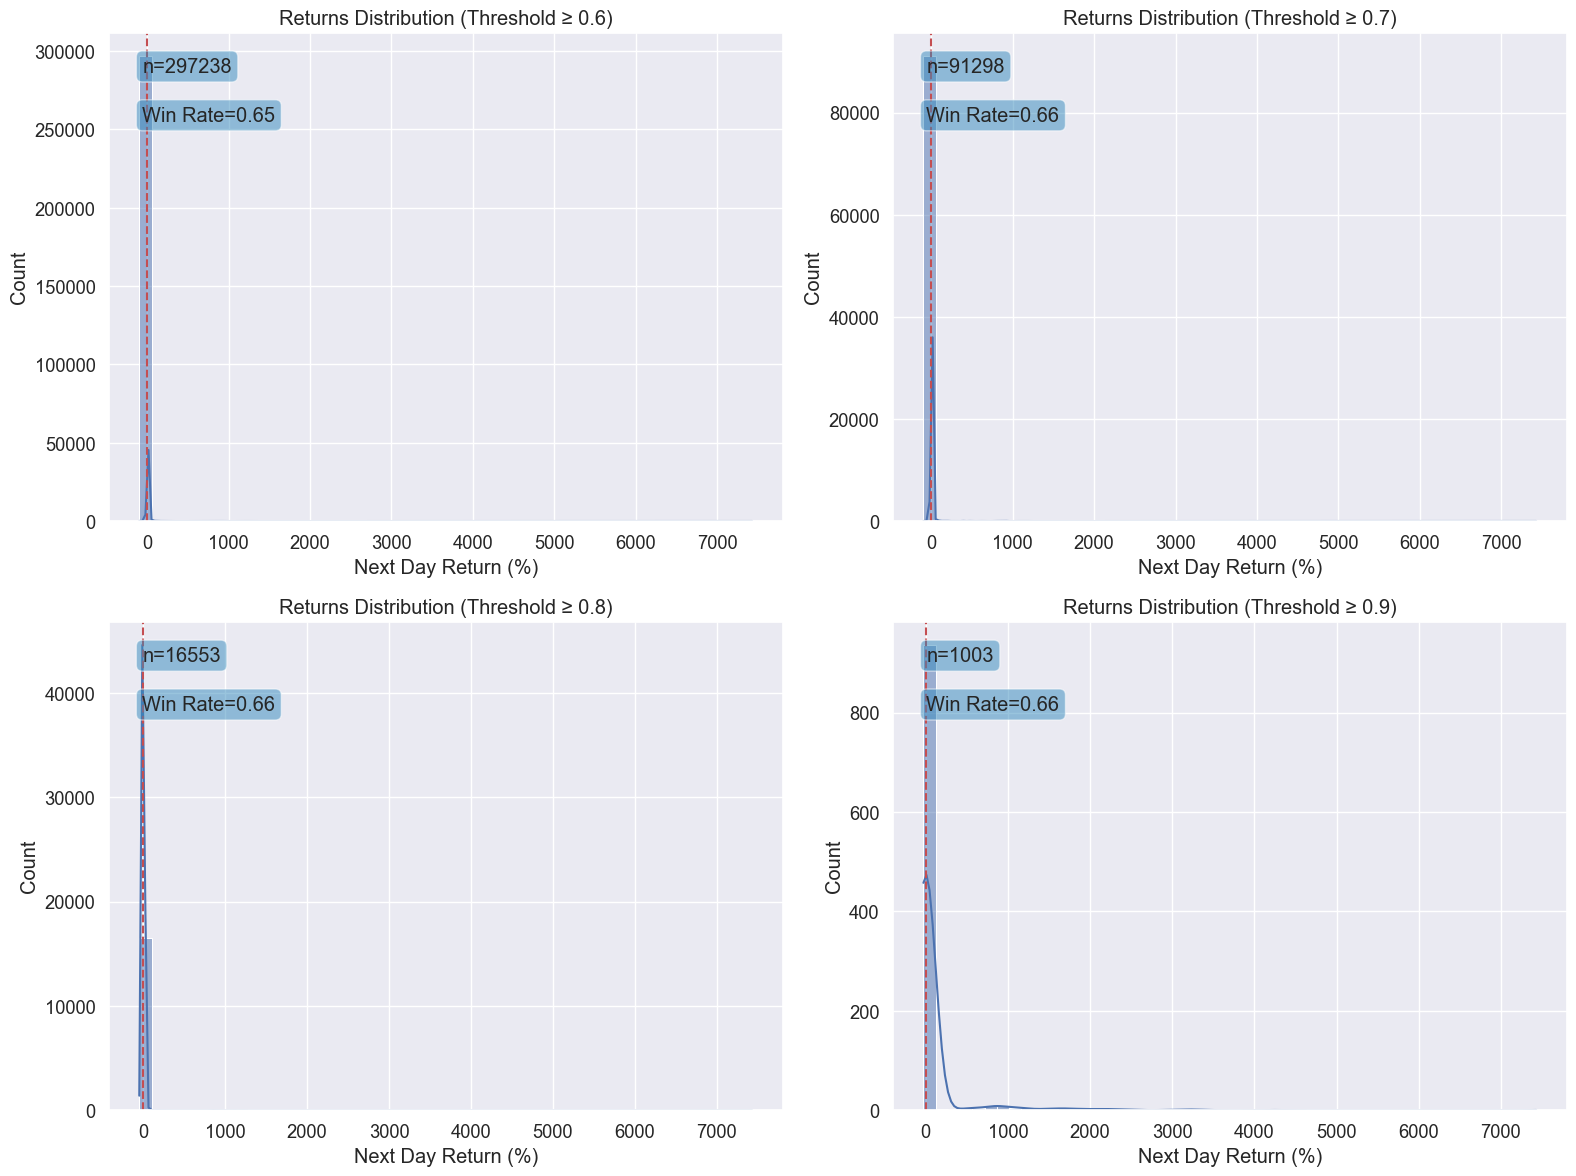


Optimal Thresholds:
Max Win Rate: 0.9800
Max Avg Return: 0.9800
Max Sharpe: 0.9800
Max Profit Factor: 0.9600
Max Kelly: 0.9600
Max Return/Drawdown: 0.9600
Max Expected Return: 0.9800

Optimal Combined Threshold: 0.9600

Performance at Optimal Combined Threshold:
Signal_Count: 88.0000
Signal_Frequency_%: 0.0080
Win_Rate: 0.7159
Avg_Return_%: 730.4470
Sharpe: 0.7056
Max_Drawdown_%: -13.7660
Profit_Factor: 1873.9677
Kelly_%: 71.5527
Expected_Return_%: 730.4470


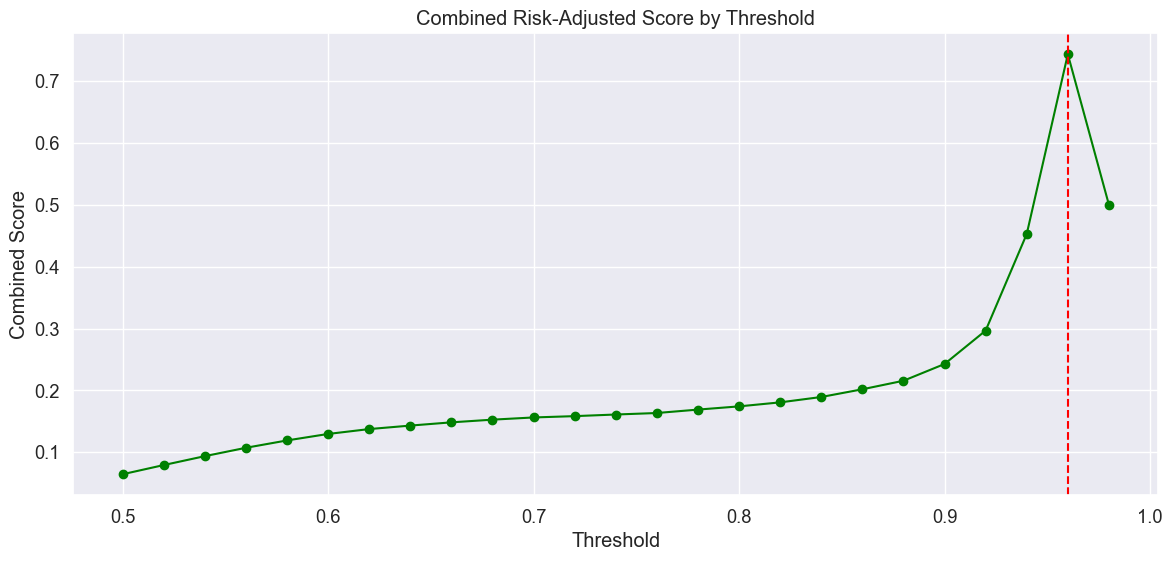


Performance by Volatility Group at Optimal Threshold:
High Volatility: Win Rate=0.8028, Avg Return=905.2304%, Signals=71
Low Volatility: Win Rate=0.3529, Avg Return=0.4690%, Signals=17
Risk metrics saved to risk_adjusted_metrics.csv


In [6]:
import os
import glob
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

def load_and_analyze_risk_adjusted_returns(max_files=100):
    """
    Load data files and analyze risk-adjusted returns for different thresholds.
    """
    # Load data files
    data_folder = "Data/RFpredictions"
    file_paths = glob.glob(os.path.join(data_folder, "*.parquet"))
    
    if max_files:
        file_paths = file_paths[:max_files]
        
    print(f"Found {len(file_paths)} parquet files")
    
    # Load the data
    stock_data = []
    
    print("Starting to load files...")
    for i, file_path in enumerate(tqdm(file_paths, desc="Loading Files")):
        try:
            table = pq.read_table(file_path)
            df = table.to_pandas()
            
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date')
            
            ticker = os.path.basename(file_path).replace('.parquet', '')
            
            # Just take recent data
            if len(df) > 252:
                df = df.iloc[-252:]
                
            required_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'UpProbability']
            if all(col in df.columns for col in required_columns):
                stock_data.append((ticker, df))

        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            
    print(f"Successfully loaded data for {len(stock_data)} stocks")
    
    # Calculate returns and prepare for analysis
    all_results = []
    prediction_outcomes = []
    
    for ticker, df in tqdm(stock_data, desc="Analyzing Predictions"):
        # Calculate various return horizons
        df['Next_Day_Return'] = df['Close'].pct_change(1).shift(-1) * 100
        df['Return_3d'] = df['Close'].pct_change(3).shift(-3) * 100
        df['Return_5d'] = df['Close'].pct_change(5).shift(-5) * 100
        df['Return_10d'] = df['Close'].pct_change(10).shift(-10) * 100
        
        # Create actual positive class label
        df['Actual_Up'] = (df['Next_Day_Return'] > 0).astype(int)
        
        # Drop rows with NaN
        df = df.dropna(subset=['UpProbability', 'Next_Day_Return', 'Actual_Up'])
        
        df['Ticker'] = ticker
        
        if len(df) > 20:  # Minimum data points per stock
            all_results.append(df)
            
            for idx, row in df.iterrows():
                prediction_outcomes.append({
                    'Ticker': ticker,
                    'Date': row['Date'],
                    'UpProbability': row['UpProbability'],
                    'Actual_Up': row['Actual_Up'],
                    'Next_Day_Return': row['Next_Day_Return'],
                    'Return_3d': row['Return_3d'],
                    'Return_5d': row['Return_5d'],
                    'Return_10d': row['Return_10d']
                })
    
    # Combine all results
    combined_df = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()
    pred_outcomes_df = pd.DataFrame(prediction_outcomes) if prediction_outcomes else pd.DataFrame()
    
    if pred_outcomes_df.empty:
        print("No valid results found.")
        return None, None, None
    
    print(f"Combined dataset has {len(combined_df)} rows and covers {combined_df['Ticker'].nunique()} stocks")
    
    # 1. Risk-Adjusted Performance Metrics by Threshold
    thresholds = np.arange(0.5, 1.0, 0.02)  # More granular around higher thresholds
    risk_metrics = []
    
    for threshold in thresholds:
        # Filter predictions above threshold
        above_threshold = pred_outcomes_df[pred_outcomes_df['UpProbability'] >= threshold]
        
        if len(above_threshold) < 10:  # Skip if too few samples
            continue
            
        # Calculate metrics
        win_rate = above_threshold['Actual_Up'].mean()
        avg_return = above_threshold['Next_Day_Return'].mean()
        std_dev = above_threshold['Next_Day_Return'].std()
        
        # Calculate various risk-adjusted metrics
        sharpe = avg_return / std_dev if std_dev > 0 else 0
        
        # Calculate max drawdown
        returns_sorted = above_threshold.sort_values('Date')
        cumulative_returns = (returns_sorted['Next_Day_Return'] / 100 + 1).cumprod() - 1
        
        if len(cumulative_returns) > 0:
            running_max = cumulative_returns.cummax()
            drawdown = (cumulative_returns - running_max) / (running_max + 1)
            max_drawdown = drawdown.min() * 100 if len(drawdown) > 0 else 0
        else:
            max_drawdown = 0
        
        # Calculate win/loss ratio and average win/loss sizes
        wins = above_threshold[above_threshold['Next_Day_Return'] > 0]
        losses = above_threshold[above_threshold['Next_Day_Return'] <= 0]
        
        avg_win = wins['Next_Day_Return'].mean() if len(wins) > 0 else 0
        avg_loss = losses['Next_Day_Return'].mean() if len(losses) > 0 else 0
        
        # Risk of ruin (simplified approximation)
        profit_factor = -avg_win * len(wins) / (avg_loss * len(losses)) if len(losses) > 0 and avg_loss < 0 else 0
        
        # Kelly criterion (optimal position sizing)
        if avg_loss < 0:
            p = win_rate
            q = 1 - p
            b = -avg_win / avg_loss if avg_loss != 0 else 0
            kelly = (p * b - q) / b if b != 0 else 0
        else:
            kelly = 0
            
        # Expected return per trade
        expected_return = win_rate * avg_win + (1 - win_rate) * avg_loss
        
        # Signal frequency
        signal_frequency = len(above_threshold) / len(pred_outcomes_df) * 100
        
        risk_metrics.append({
            'Threshold': threshold,
            'Signal_Count': len(above_threshold),
            'Signal_Frequency_%': signal_frequency,
            'Win_Rate': win_rate,
            'Avg_Return_%': avg_return,
            'StdDev_%': std_dev,
            'Sharpe': sharpe,
            'Max_Drawdown_%': max_drawdown,
            'Avg_Win_%': avg_win,
            'Avg_Loss_%': avg_loss,
            'Win_Loss_Ratio': -avg_win / avg_loss if avg_loss < 0 else np.inf,
            'Profit_Factor': profit_factor,
            'Kelly_%': kelly * 100,
            'Expected_Return_%': expected_return
        })
    
    risk_df = pd.DataFrame(risk_metrics)
    
    # 2. Plot key risk-adjusted metrics by threshold
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Plot win rate and average return
    ax1 = axes[0, 0]
    ax1.plot(risk_df['Threshold'], risk_df['Win_Rate'], '-o', color='blue', label='Win Rate')
    ax1.set_ylabel('Win Rate', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(risk_df['Threshold'], risk_df['Avg_Return_%'], '-^', color='green', label='Avg Return')
    ax1_twin.set_ylabel('Average Return (%)', color='green')
    ax1_twin.tick_params(axis='y', labelcolor='green')
    
    ax1.set_title('Win Rate and Average Return by Threshold')
    ax1.set_xlabel('Threshold')
    
    # Plot signal frequency and expected return
    ax2 = axes[0, 1]
    ax2.plot(risk_df['Threshold'], risk_df['Signal_Frequency_%'], '-o', color='red', label='Signal Frequency')
    ax2.set_ylabel('Signal Frequency (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax2_twin = ax2.twinx()
    ax2_twin.plot(risk_df['Threshold'], risk_df['Expected_Return_%'], '-^', color='purple', label='Expected Return')
    ax2_twin.set_ylabel('Expected Return (%)', color='purple')
    ax2_twin.tick_params(axis='y', labelcolor='purple')
    
    ax2.set_title('Signal Frequency and Expected Return by Threshold')
    ax2.set_xlabel('Threshold')
    
    # Plot Sharpe ratio and profit factor
    ax3 = axes[1, 0]
    ax3.plot(risk_df['Threshold'], risk_df['Sharpe'], '-o', color='cyan', label='Sharpe Ratio')
    ax3.set_ylabel('Sharpe Ratio', color='cyan')
    ax3.tick_params(axis='y', labelcolor='cyan')
    
    ax3_twin = ax3.twinx()
    ax3_twin.plot(risk_df['Threshold'], risk_df['Profit_Factor'], '-^', color='magenta', label='Profit Factor')
    ax3_twin.set_ylabel('Profit Factor', color='magenta')
    ax3_twin.tick_params(axis='y', labelcolor='magenta')
    
    ax3.set_title('Sharpe Ratio and Profit Factor by Threshold')
    ax3.set_xlabel('Threshold')
    
    # Plot Kelly criterion and max drawdown
    ax4 = axes[1, 1]
    ax4.plot(risk_df['Threshold'], risk_df['Kelly_%'], '-o', color='orange', label='Kelly %')
    ax4.set_ylabel('Kelly %', color='orange')
    ax4.tick_params(axis='y', labelcolor='orange')
    
    ax4_twin = ax4.twinx()
    ax4_twin.plot(risk_df['Threshold'], np.abs(risk_df['Max_Drawdown_%']), '-^', color='brown', label='Max Drawdown')
    ax4_twin.set_ylabel('Max Drawdown (%)', color='brown')
    ax4_twin.tick_params(axis='y', labelcolor='brown')
    
    ax4.set_title('Kelly % and Max Drawdown by Threshold')
    ax4.set_xlabel('Threshold')
    
    plt.tight_layout()
    plt.suptitle('Risk-Adjusted Performance Metrics by UpProbability Threshold', fontsize=16)
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # 3. Plot returns distribution at different thresholds
    thresholds_to_plot = [0.6, 0.7, 0.8, 0.9]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, threshold in enumerate(thresholds_to_plot):
        filtered_data = pred_outcomes_df[pred_outcomes_df['UpProbability'] >= threshold]
        if len(filtered_data) > 10:
            sns.histplot(filtered_data['Next_Day_Return'], bins=50, kde=True, ax=axes[i])
            axes[i].set_title(f'Returns Distribution (Threshold ≥ {threshold})')
            axes[i].set_xlabel('Next Day Return (%)')
            axes[i].axvline(0, color='r', linestyle='--')
            axes[i].text(0.05, 0.95, f'n={len(filtered_data)}', transform=axes[i].transAxes,
                        verticalalignment='top', bbox={'boxstyle':'round', 'alpha':0.5})
            win_rate = (filtered_data['Next_Day_Return'] > 0).mean()
            axes[i].text(0.05, 0.85, f'Win Rate={win_rate:.2f}', transform=axes[i].transAxes,
                        verticalalignment='top', bbox={'boxstyle':'round', 'alpha':0.5})
    
    plt.tight_layout()
    plt.show()
    
    # 4. Calculate the optimal threshold for different risk preferences
    # Create columns for different risk-adjusted metrics
    risk_df['Return_to_Drawdown'] = risk_df['Avg_Return_%'] / np.abs(risk_df['Max_Drawdown_%'])
    risk_df['Return_to_Drawdown'] = risk_df['Return_to_Drawdown'].replace([np.inf, -np.inf], 0)
    
    # Find optimal thresholds for different metrics
    optimal_thresholds = {
        'Max Win Rate': risk_df.loc[risk_df['Win_Rate'].idxmax(), 'Threshold'],
        'Max Avg Return': risk_df.loc[risk_df['Avg_Return_%'].idxmax(), 'Threshold'],
        'Max Sharpe': risk_df.loc[risk_df['Sharpe'].idxmax(), 'Threshold'],
        'Max Profit Factor': risk_df.loc[risk_df['Profit_Factor'].idxmax(), 'Threshold'],
        'Max Kelly': risk_df.loc[risk_df['Kelly_%'].idxmax(), 'Threshold'],
        'Max Return/Drawdown': risk_df.loc[risk_df['Return_to_Drawdown'].idxmax(), 'Threshold'],
        'Max Expected Return': risk_df.loc[risk_df['Expected_Return_%'].idxmax(), 'Threshold']
    }
    
    print("\nOptimal Thresholds:")
    for metric, threshold in optimal_thresholds.items():
        print(f"{metric}: {threshold:.4f}")
    
    # 5. Combined risk score and optimal threshold
    # Normalize and weight different metrics to create a combined score
    # Note: This approach allows you to customize which metrics matter most to you
    
    # Normalize metrics between 0 and 1
    metrics_to_normalize = ['Win_Rate', 'Avg_Return_%', 'Sharpe', 'Profit_Factor', 'Kelly_%', 'Return_to_Drawdown']
    normalized_df = risk_df.copy()
    
    for metric in metrics_to_normalize:
        if normalized_df[metric].max() > normalized_df[metric].min():
            normalized_df[metric] = (normalized_df[metric] - normalized_df[metric].min()) / (normalized_df[metric].max() - normalized_df[metric].min())
    
    # Create weighted score (customize these weights based on your risk preference)
    weights = {
        'Win_Rate': 0.15,
        'Avg_Return_%': 0.15,
        'Sharpe': 0.2,
        'Profit_Factor': 0.2,
        'Kelly_%': 0.15,
        'Return_to_Drawdown': 0.15
    }
    
    normalized_df['Combined_Score'] = sum(normalized_df[metric] * weight for metric, weight in weights.items())
    
    # Find optimal threshold based on combined score
    optimal_combined_threshold = normalized_df.loc[normalized_df['Combined_Score'].idxmax(), 'Threshold']
    
    print(f"\nOptimal Combined Threshold: {optimal_combined_threshold:.4f}")
    
    # Show performance at optimal combined threshold
    optimal_row = risk_df[risk_df['Threshold'] == optimal_combined_threshold].iloc[0]
    print("\nPerformance at Optimal Combined Threshold:")
    for metric in ['Signal_Count', 'Signal_Frequency_%', 'Win_Rate', 'Avg_Return_%', 'Sharpe', 
                  'Max_Drawdown_%', 'Profit_Factor', 'Kelly_%', 'Expected_Return_%']:
        print(f"{metric}: {optimal_row[metric]:.4f}")
    
    # 6. Plot the combined score
    plt.figure(figsize=(14, 6))
    plt.plot(normalized_df['Threshold'], normalized_df['Combined_Score'], '-o', color='green')
    plt.axvline(optimal_combined_threshold, color='red', linestyle='--')
    plt.title('Combined Risk-Adjusted Score by Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Combined Score')
    plt.grid(True)
    plt.show()
    
    # 7. Analyze signals by stock type (volatility groups)
    # Group stocks by their volatility to see if threshold effectiveness varies
    if 'volatility' in combined_df.columns:
        # Calculate median volatility for grouping
        median_vol = combined_df['volatility'].median()
        
        # Group by high and low volatility
        combined_df['Volatility_Group'] = combined_df['volatility'].apply(
            lambda x: 'High' if x > median_vol else 'Low')
        
        # Filter at optimal threshold
        high_vol_df = combined_df[(combined_df['Volatility_Group'] == 'High') & 
                                 (combined_df['UpProbability'] >= optimal_combined_threshold)]
        low_vol_df = combined_df[(combined_df['Volatility_Group'] == 'Low') & 
                                (combined_df['UpProbability'] >= optimal_combined_threshold)]
        
        # Calculate performance metrics by volatility group
        vol_performance = {
            'High Volatility': {
                'Win Rate': high_vol_df['Actual_Up'].mean(),
                'Avg Return': high_vol_df['Next_Day_Return'].mean(),
                'Signal Count': len(high_vol_df)
            },
            'Low Volatility': {
                'Win Rate': low_vol_df['Actual_Up'].mean(),
                'Avg Return': low_vol_df['Next_Day_Return'].mean(),
                'Signal Count': len(low_vol_df)
            }
        }
        
        print("\nPerformance by Volatility Group at Optimal Threshold:")
        for group, metrics in vol_performance.items():
            print(f"{group}: Win Rate={metrics['Win Rate']:.4f}, Avg Return={metrics['Avg Return']:.4f}%, Signals={metrics['Signal Count']}")
    
    # Return dataframes for further analysis
    return combined_df, pred_outcomes_df, risk_df

# Execute the analysis 
combined_df, pred_outcomes_df, risk_df = load_and_analyze_risk_adjusted_returns(max_files=None)

# If you want to save the risk metrics to a CSV for further analysis
if risk_df is not None:
    risk_df.to_csv('risk_adjusted_metrics.csv', index=False)
    print("Risk metrics saved to risk_adjusted_metrics.csv")